In [1]:
#default_exp verbatims/standard_themes_css/training

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Standard CSS Themes - Training

> This module contains all the bits required to train and evaluate CSS standard theme models

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm

from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

In [8]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_CSS_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

In [9]:
df = get_css_standard_theme_train_data()
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

dls = get_css_standard_theme_train_dls(df, hf_arch, hf_tokenizer)

In [10]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 324]), torch.Size([8, 16]))

## Training

In [11]:
m_pre = f'exp_{m_pre_standard_themes_css}'
m_suf = m_suf_standard_themes_css

Configure our **metrics**

In [12]:
# define metrics
beta, start, end, average, sample_weight = .5, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

In [13]:
#export
def get_metrics(train_config={}):
    config = {**css_standard_themes_train_config, **train_config}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [14]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [15]:
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [16]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [17]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our callbacks

In [19]:
best_model_cb = SaveModelCallback(monitor='precision_score', 
                                  comp=np.greater, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, 
                                            average=average, 
                                            sample_weight=sample_weight,
                                            start=start, end=end)

In [20]:
#export
def get_cbs(train_config={}):
    config = {**css_standard_themes_train_config, **train_config}
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    return [HF_BaseModelCallback], [best_model_cb, opt_thresh_cb] # (learn_cbs, fit_cbs)

Define our Learner

In [21]:
learn_metrics = [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [best_model_cb, opt_thresh_cb]

# build learner
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=STANDARD_THEME_CSS_PATH)

learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [22]:
# learn.blurr_summary()

In [23]:
# learn.show_training_loop()

In [24]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0].shape

In [25]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                train_config={}):
    config = {**css_standard_themes_train_config, **train_config}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config)
    learn_metrics = get_metrics(config)

    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(0.002290867641568184, 0.0003981071640737355)

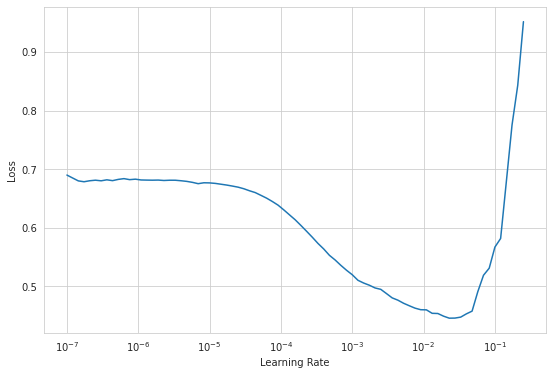

In [26]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [27]:
learn.fit_one_cycle(3, lr_max=lr_min, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.193112,0.204425,0.921516,0.526039,0.634973,0.514286,0.727529,0.260000,00:23
1,0.141910,0.154947,0.943443,0.628776,0.646104,0.610390,0.786926,0.350000,00:23
2,0.108089,0.143548,0.950820,0.670097,0.718065,0.561039,0.769725,0.490000,00:23


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.6349734567608504.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.6461038449506864.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with precision_score value: 0.7180650608609523.


(2.2908675418875645e-07, 1.0964781722577754e-06)

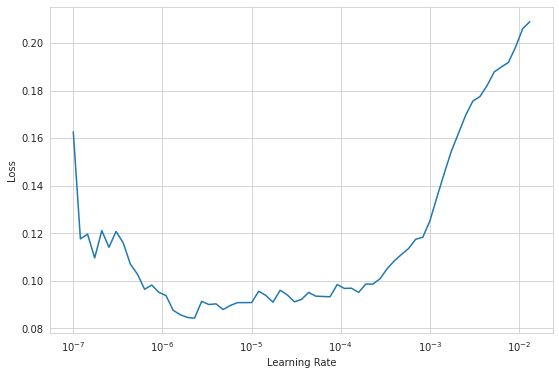

In [28]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [29]:
learn.fit_one_cycle(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.090436,0.143399,0.951230,0.669734,0.730637,0.535065,0.758108,0.540000,00:45
1,0.098161,0.143281,0.951230,0.669729,0.730380,0.535065,0.758192,0.540000,00:45
2,0.094971,0.143236,0.951230,0.668917,0.723565,0.545455,0.762897,0.520000,00:45
3,0.083291,0.143170,0.951230,0.668843,0.725569,0.542857,0.761740,0.530000,00:45
4,0.090575,0.143172,0.951230,0.668843,0.725569,0.542857,0.761740,0.530000,00:45


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.730637340261846.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [30]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.5299999999999998

In [31]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/standard_themes/css/models/exp_cls_multilabel_hf.pth')

Export model for inference

In [32]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [33]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [34]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'valid_loss': 0.14339925348758698,
 'accuracy_multi': 0.9506147503852844,
 'fbeta_score': 0.6651649065945805,
 'precision_score': 0.723356742072157,
 'recall_score': 0.535064935064935,
 'roc_auc_score': 0.757656526354621,
 'opt_th': 0.5299999999999998}

In [35]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Use it for inference

In [36]:
inf_learn = load_learner(STANDARD_THEME_CSS_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [37]:
inf_learn.loss_func.thresh

0.5299999999999998

In [38]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

((#1) ['cost_fees'],
 tensor([False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False]),
 tensor([6.9475e-03, 1.0225e-03, 8.1517e-01, 4.0517e-03, 1.6105e-03, 1.9530e-03,
         2.0025e-02, 1.4429e-03, 2.6958e-04, 1.0739e-01, 2.7601e-03, 3.3394e-03,
         3.3170e-04, 2.2693e-03, 8.5260e-04, 1.0502e-02]))

Review final validation loss for best model

In [39]:
print(STANDARD_THEME_CSS_LABELS)

['accessible_to_customers', 'consistency_in_policies_information', 'cost_fees', 'courteous_professional_staff', 'effective_communications', 'effectively_uses_websites_online_documentation', 'helpful_staff', 'knowledgeable_staff', 'moving_in_a_positive_direction', 'overall_satisfaction', 'process_improvement', 'provides_effective_advice_guidance', 'provides_training_on_processes_applications', 'resolves_problems_effectively', 'responds_to_requests_within_an_acceptable_time', 'understands_my_needs_and_requirements']


In [40]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [41]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Loss: 0.14339925348758698


In [42]:
learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

((#0) [],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False]),
 tensor([0.0016, 0.0017, 0.0011, 0.0604, 0.0011, 0.0006, 0.4411, 0.0047, 0.0029,
         0.1454, 0.0017, 0.0084, 0.0005, 0.0012, 0.0011, 0.0867]))

## Review

### Lets look at validation metrics

In [43]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(torch.Size([305, 16]), torch.Size([305, 16]), 305, 16, 0.5299999999999998)

In [44]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [45]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.4800000000000001, 0.26000000000000006, 0.1)

In [46]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.6660428010621502, 0.6347669847289614, 0.6944761079133782)

In [47]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=.5, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.6660428010621502

In [48]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9502049088478088, 0.9383196830749512, 0.903073787689209)

In [49]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.9502049088478088

### Overall metrics

In [50]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [51]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f05), sample_weight=sample_weight))

0.49508196721311476


In [52]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.9502049180327868


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [53]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 4495


In [54]:
most_freq_class_count / len(eval_targs)

0.9211065573770492

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [55]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.61587747883154


#### Confusion Matrix

Describes the performance of a classification model

In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [57]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

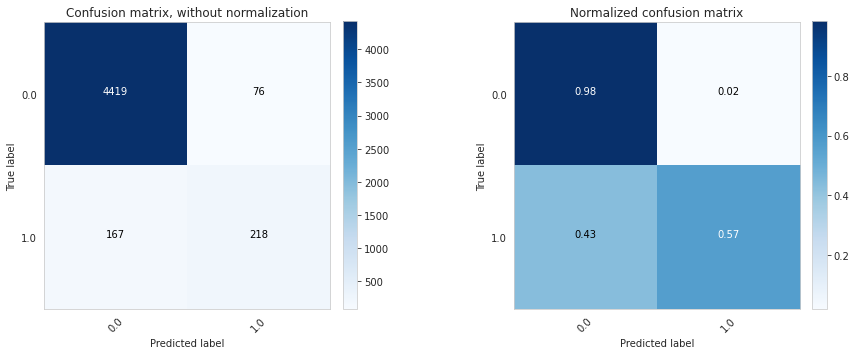

In [58]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [59]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f05).float(), sample_weight=sample_weight)

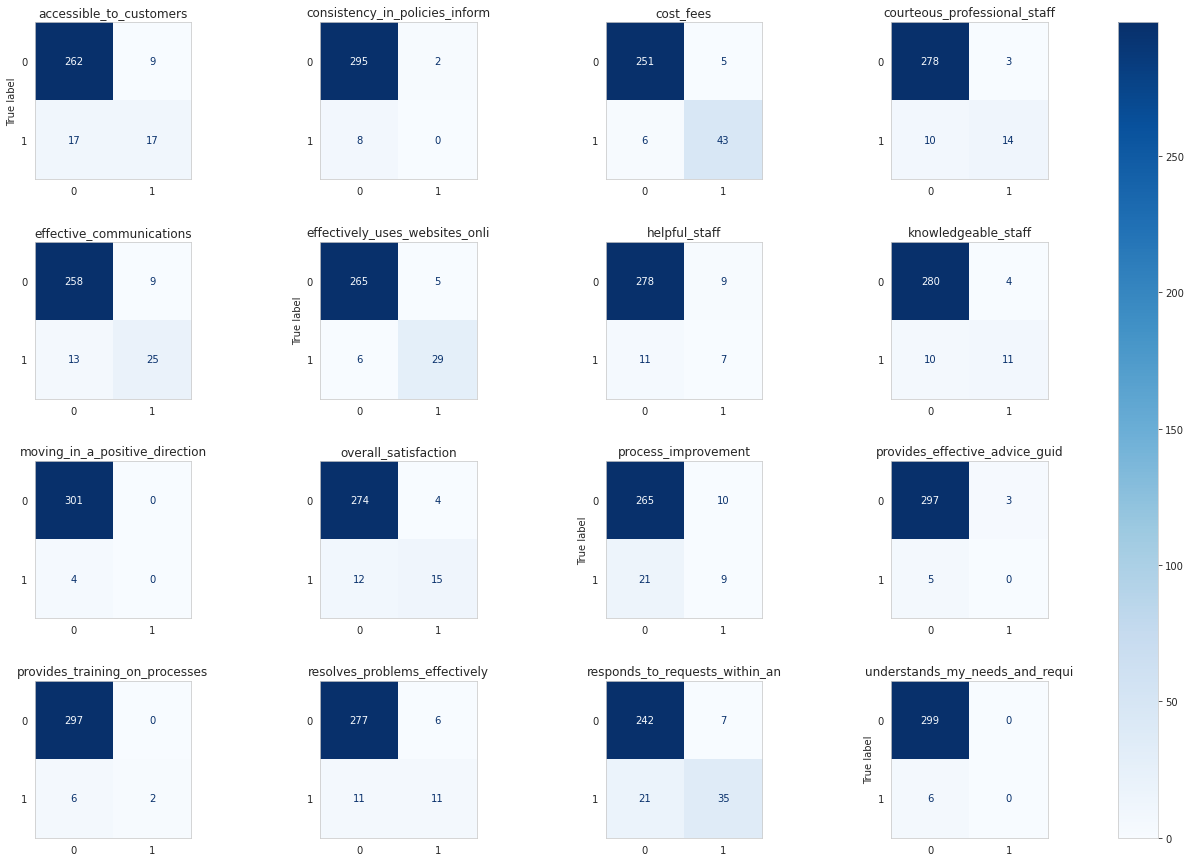

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(4, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(16):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(STANDARD_THEME_CSS_LABELS[i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [61]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4495
           1       0.74      0.57      0.64       385

    accuracy                           0.95      4880
   macro avg       0.85      0.77      0.81      4880
weighted avg       0.95      0.95      0.95      4880



In [62]:
classification_report = skm.classification_report(targs, (probs > threshold_f05).float(), 
                                target_names=STANDARD_THEME_CSS_LABELS,
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
accessible_to_customers,0.653846,0.500000,0.566667,34.0
consistency_in_policies_information,0.000000,0.000000,0.000000,8.0
cost_fees,0.895833,0.877551,0.886598,49.0
courteous_professional_staff,0.823529,0.583333,0.682927,24.0
effective_communications,0.735294,0.657895,0.694444,38.0
effectively_uses_websites_online_documentation,0.852941,0.828571,0.840580,35.0
helpful_staff,0.437500,0.388889,0.411765,18.0
knowledgeable_staff,0.733333,0.523810,0.611111,21.0
moving_in_a_positive_direction,1.000000,0.000000,0.000000,4.0
overall_satisfaction,0.789474,0.555556,0.652174,27.0


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

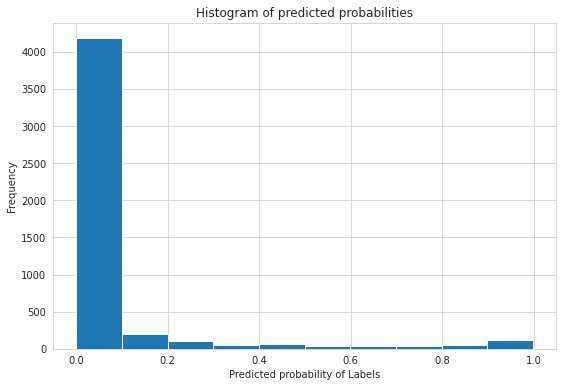

In [63]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [64]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

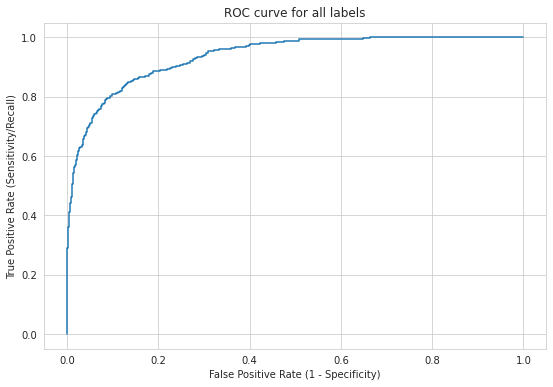

In [65]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [66]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9365274547476995


### Let's look at things by label by label

In [67]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_CSS_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
# label_metrics

ACCESSIBLE_TO_CUSTOMERS

Null Accuracy:	0.8885245901639345
AUC Score:	0.8545691339266334

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9147540983606557	0.8950819672131147	0.8262295081967214	
Cohen's Kappa:	0.5203242196951368	0.49628406275805126	0.39509037159001603	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9391              0.9668              0.9527              271                 
1                   0.6538              0.5                 0.5667              34                  
avg/total           0.7965              0.7334              0.7597              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9476              0.9336              0.9405              271                 
1                   0.5263              0.5882              0.5556      

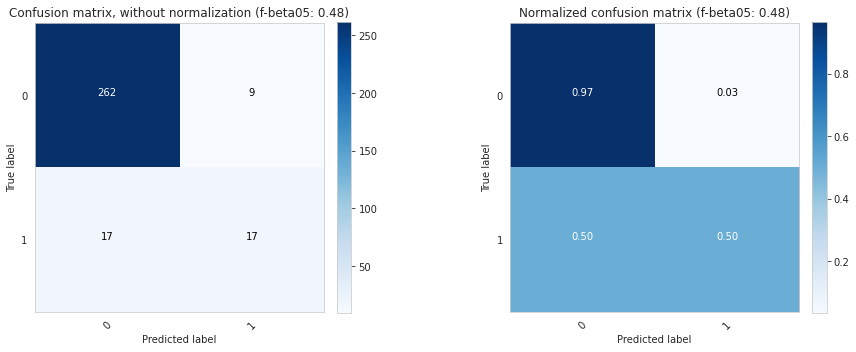

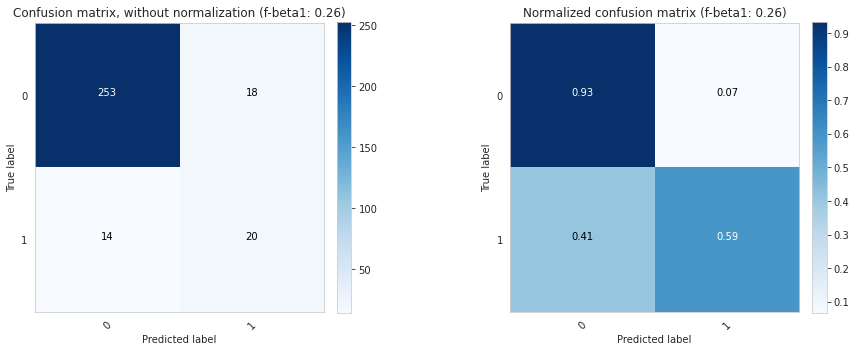

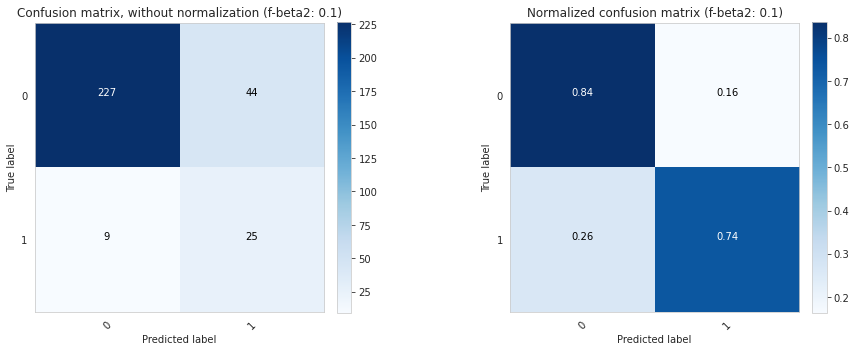



ROC Curve:


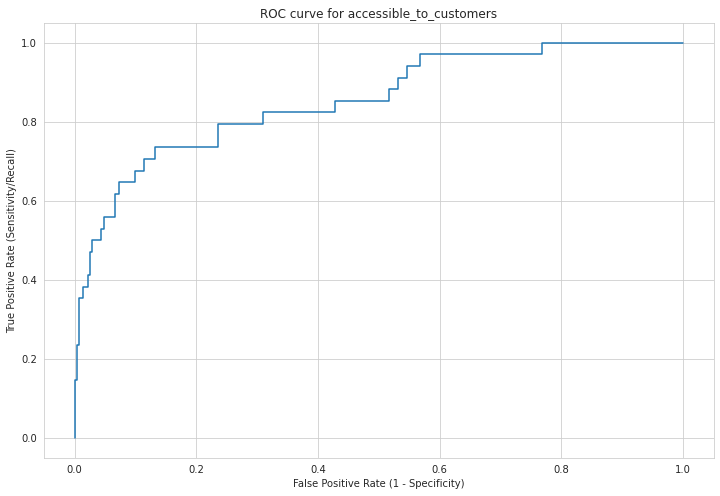

Predicted Probability Distribution:


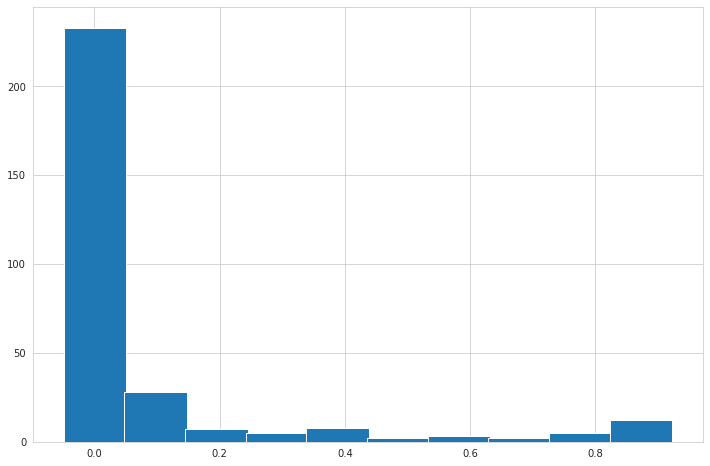



----------------------------------------------------------------------------------------------------


CONSISTENCY_IN_POLICIES_INFORMATION

Null Accuracy:	0.9737704918032787
AUC Score:	0.8846801346801346

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9672131147540983	0.9704918032786886	0.9508196721311475	
Cohen's Kappa:	-0.010603048376408353	0.2934362934362934	0.2617395513958367	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9736              0.9933              0.9833              297                 
1                   0.0                 0.0                 0.0                 8                   
avg/total           0.4868              0.4966              0.4917              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.98                0.9899         

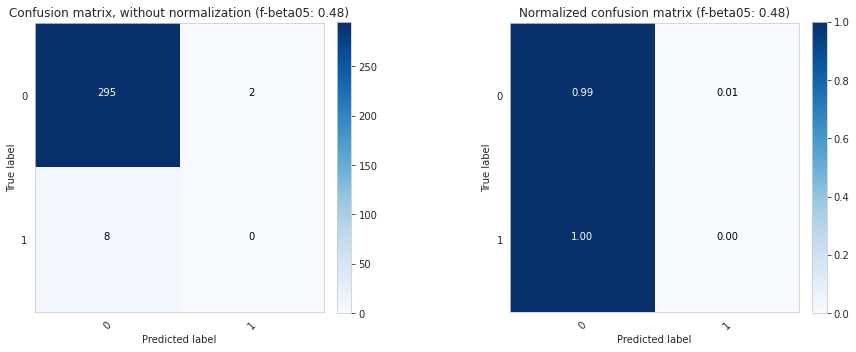

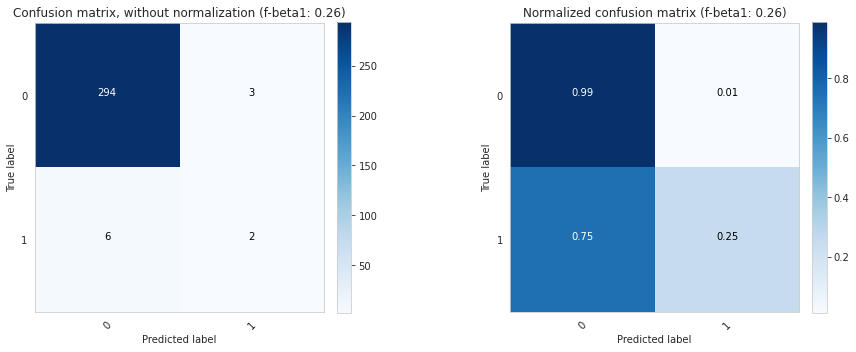

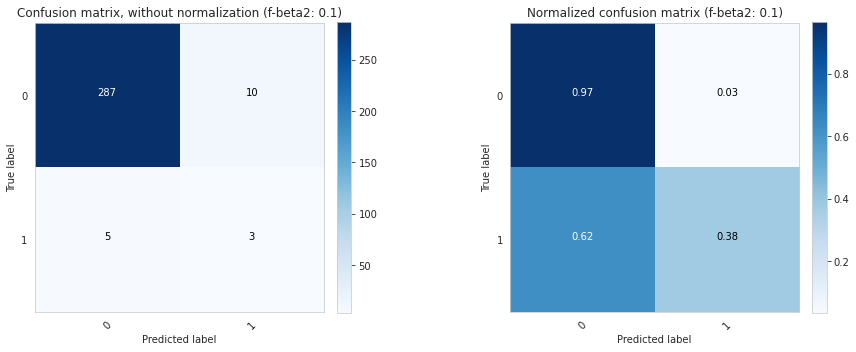



ROC Curve:


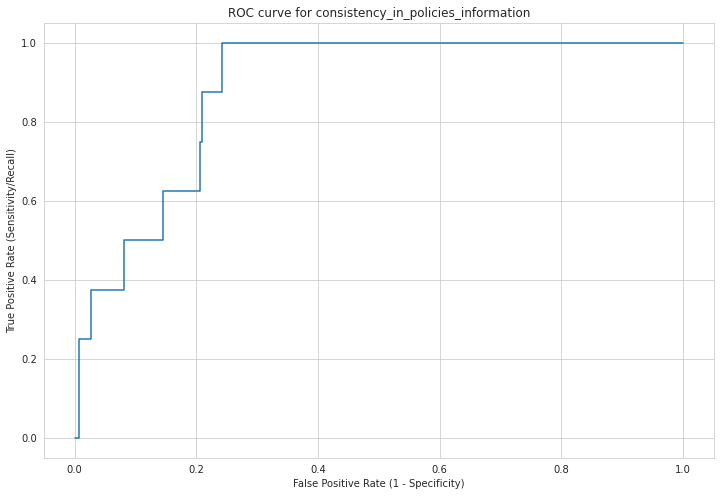

Predicted Probability Distribution:


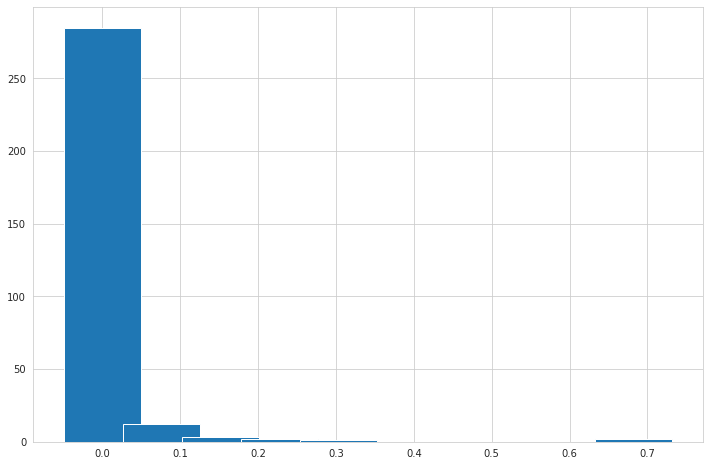



----------------------------------------------------------------------------------------------------


COST_FEES

Null Accuracy:	0.839344262295082
AUC Score:	0.9847735969387755

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9639344262295082	0.9573770491803278	0.9475409836065574	
Cohen's Kappa:	0.8651581528073631	0.8432496540818344	0.8175291654202812	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9767              0.9805              0.9786              256                 
1                   0.8958              0.8776              0.8866              49                  
avg/total           0.9362              0.929               0.9326              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9765              0.9727              0.9746              256  

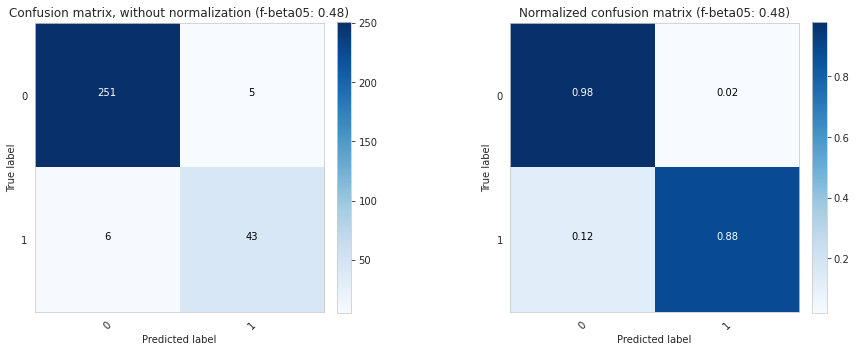

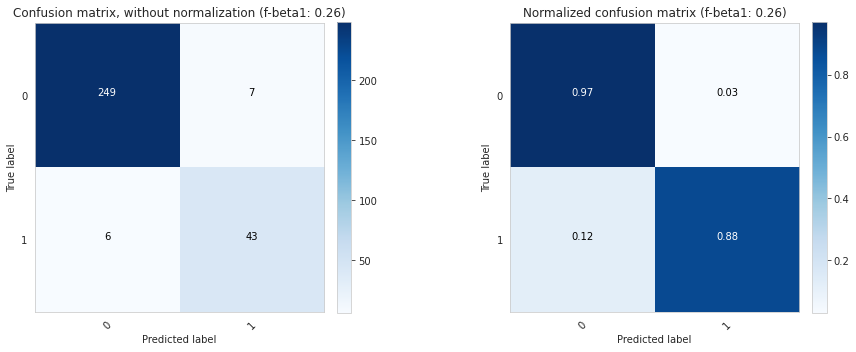

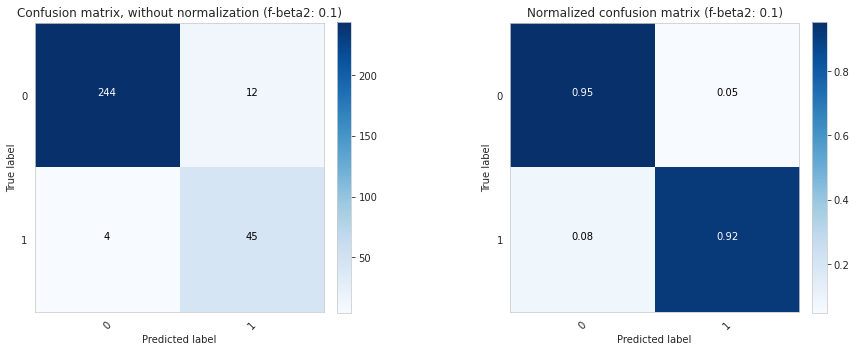



ROC Curve:


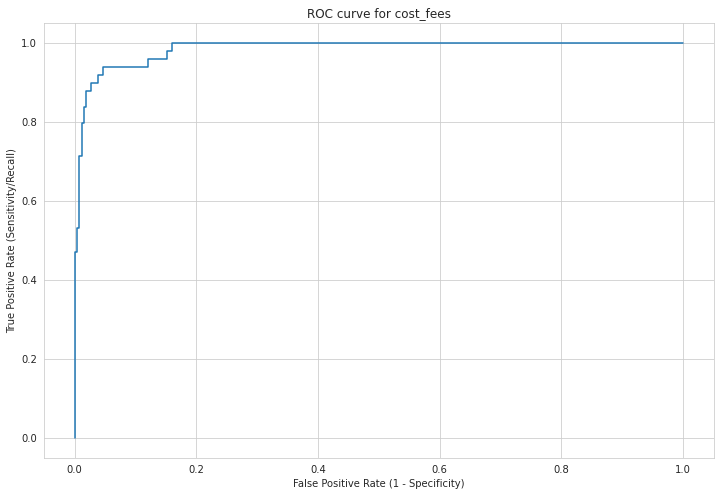

Predicted Probability Distribution:


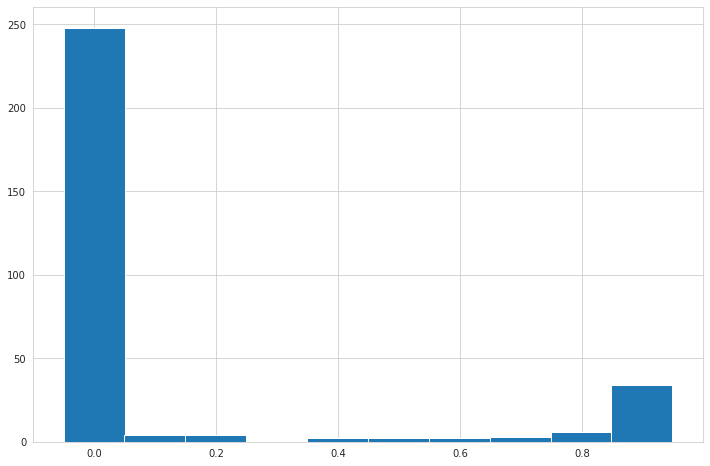



----------------------------------------------------------------------------------------------------


COURTEOUS_PROFESSIONAL_STAFF

Null Accuracy:	0.921311475409836
AUC Score:	0.971085409252669

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9573770491803278	0.9508196721311475	0.9344262295081968	
Cohen's Kappa:	0.6607921977927966	0.7007261071498658	0.6429825588200866	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9653              0.9893              0.9772              281                 
1                   0.8235              0.5833              0.6829              24                  
avg/total           0.8944              0.7863              0.83                305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9854              0.9609              0.973  

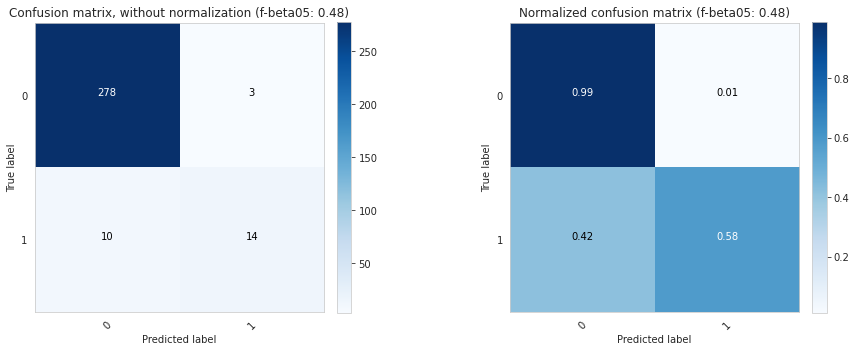

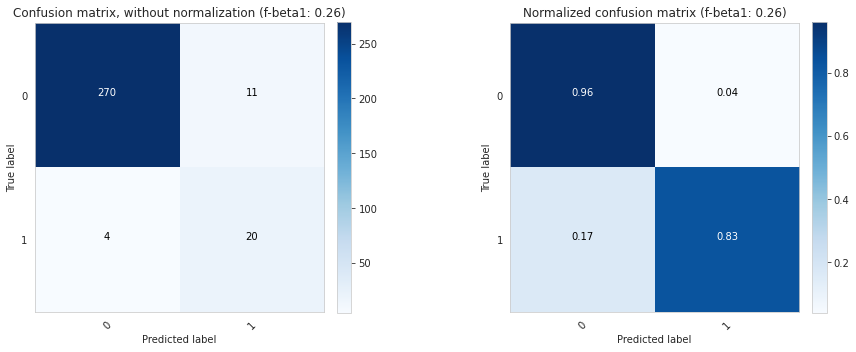

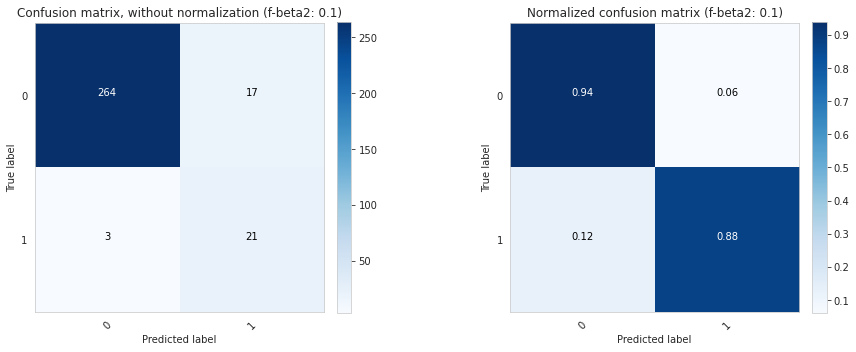



ROC Curve:


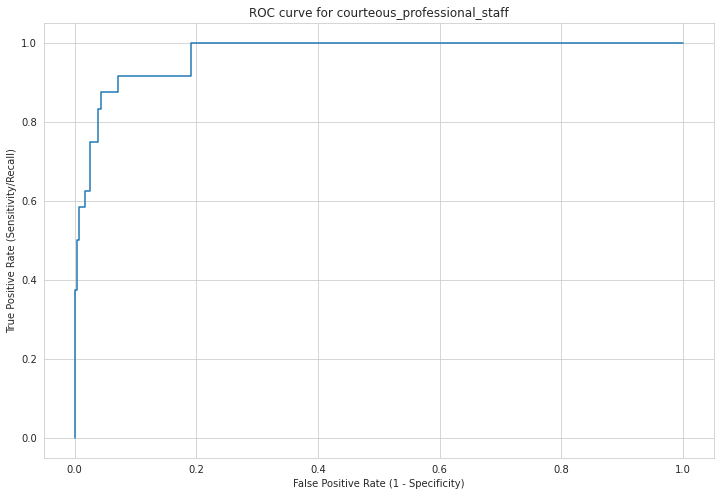

Predicted Probability Distribution:


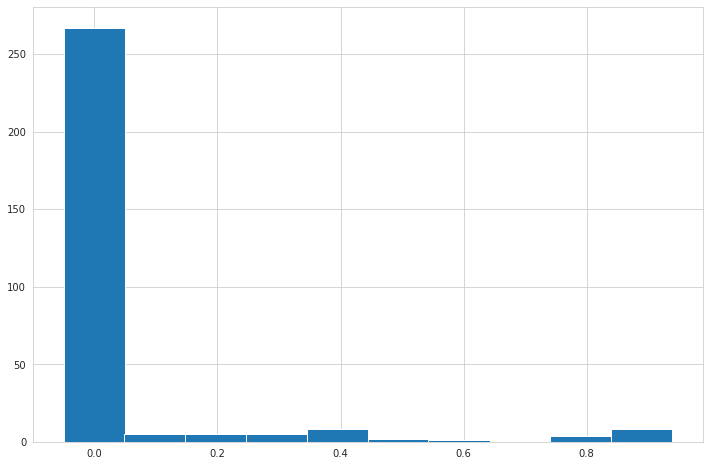



----------------------------------------------------------------------------------------------------


EFFECTIVE_COMMUNICATIONS

Null Accuracy:	0.8754098360655738
AUC Score:	0.9337670017740982

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9278688524590164	0.9245901639344263	0.8819672131147541	
Cohen's Kappa:	0.6536952931461602	0.6656179989513323	0.566521910777734	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.952               0.9663              0.9591              267                 
1                   0.7353              0.6579              0.6944              38                  
avg/total           0.8437              0.8121              0.8268              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9621              0.9513              0.9567    

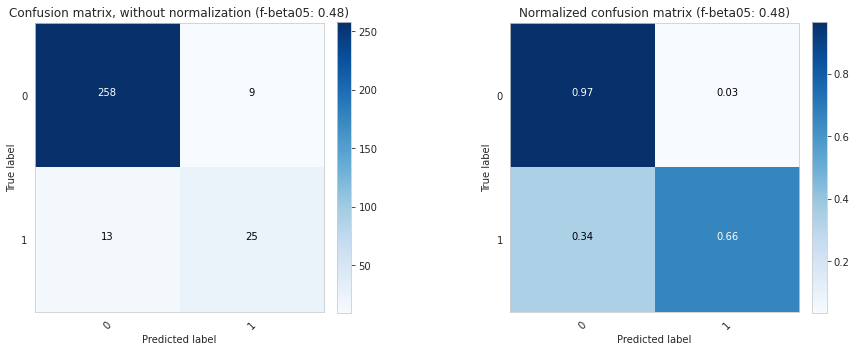

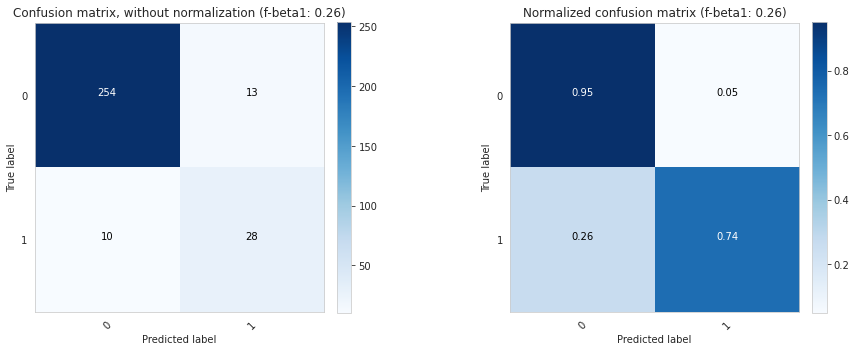

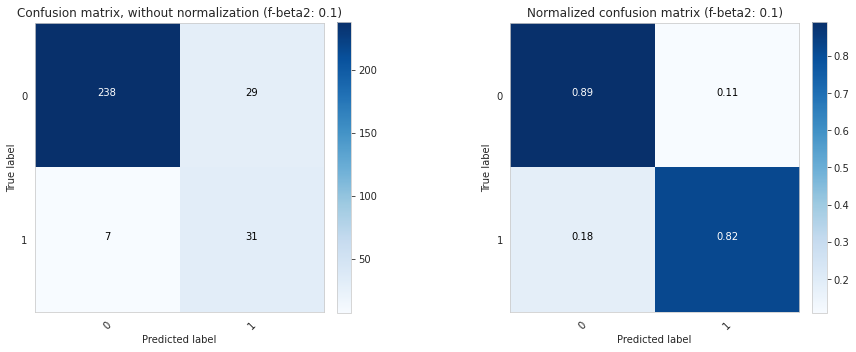



ROC Curve:


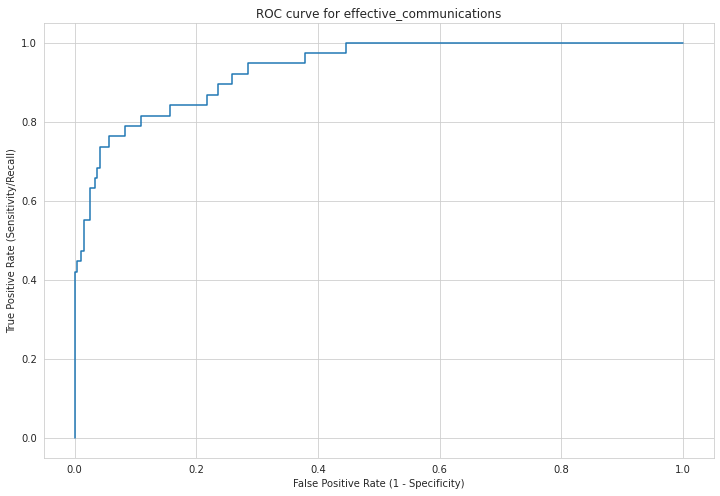

Predicted Probability Distribution:


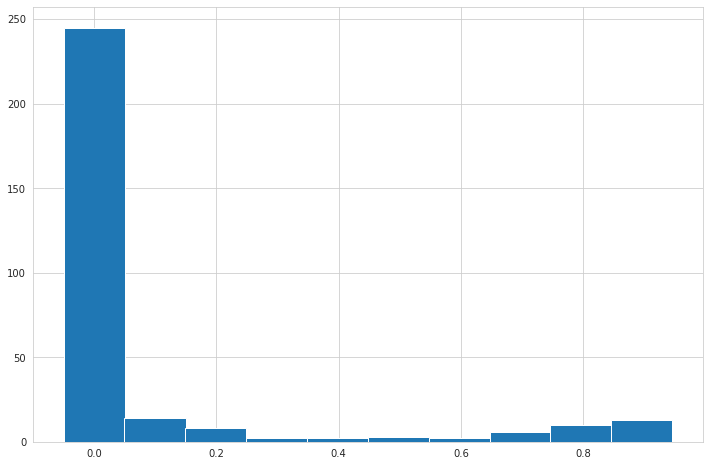



----------------------------------------------------------------------------------------------------


EFFECTIVELY_USES_WEBSITES_ONLINE_DOCUMENTATION

Null Accuracy:	0.8852459016393442
AUC Score:	0.9710052910052909

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9639344262295082	0.940983606557377	0.9016393442622951	
Cohen's Kappa:	0.8202518081971605	0.7358036573628488	0.6271393643031785	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9779              0.9815              0.9797              270                 
1                   0.8529              0.8286              0.8406              35                  
avg/total           0.9154              0.905               0.9101              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9809              0.9519  

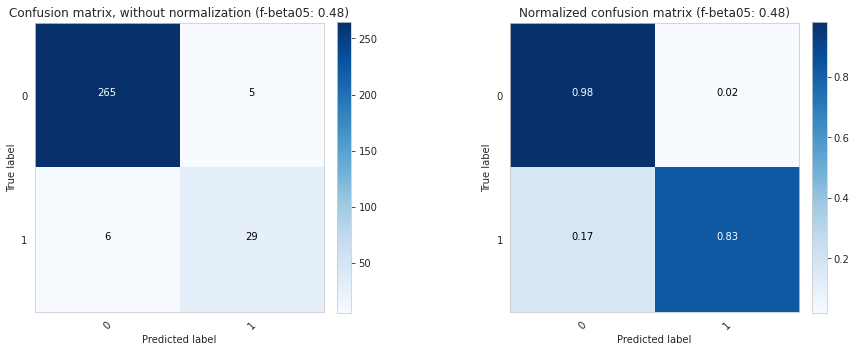

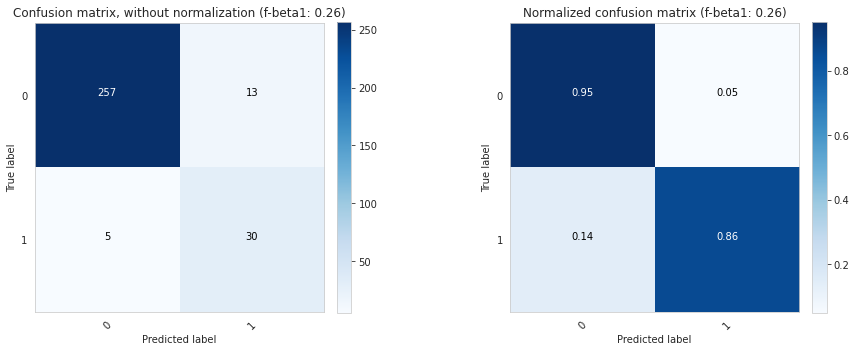

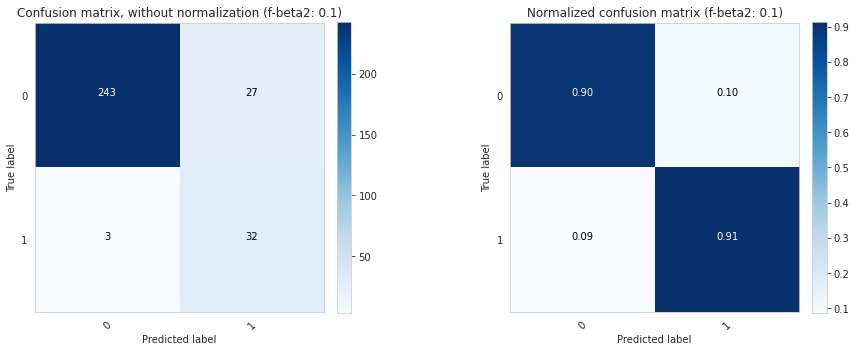



ROC Curve:


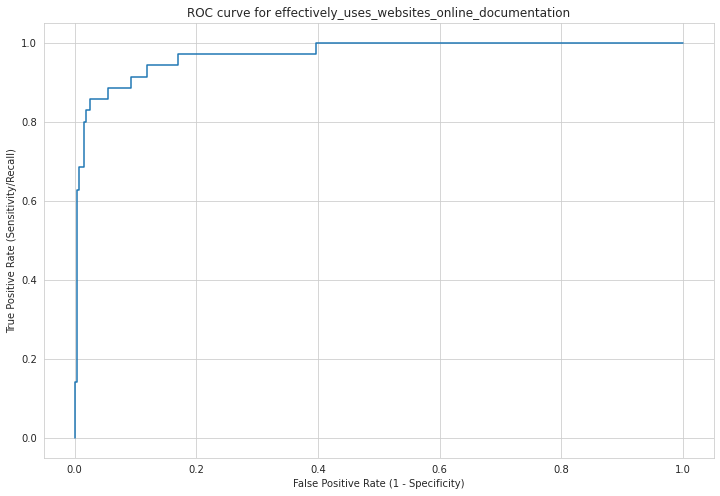

Predicted Probability Distribution:


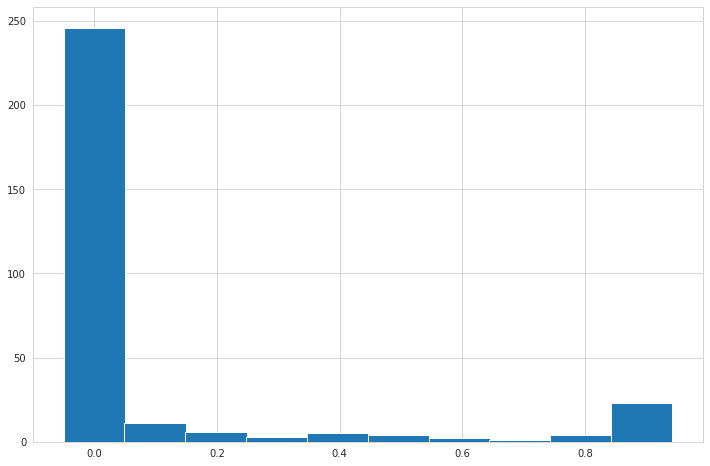



----------------------------------------------------------------------------------------------------


HELPFUL_STAFF

Null Accuracy:	0.940983606557377
AUC Score:	0.881339527680991

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9344262295081968	0.9180327868852459	0.8229508196721311	
Cohen's Kappa:	0.3771696957320809	0.4263035136558574	0.23855755894590847	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9619              0.9686              0.9653              287                 
1                   0.4375              0.3889              0.4118              18                  
avg/total           0.6997              0.6788              0.6885              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9746              0.9373              0.9556              2

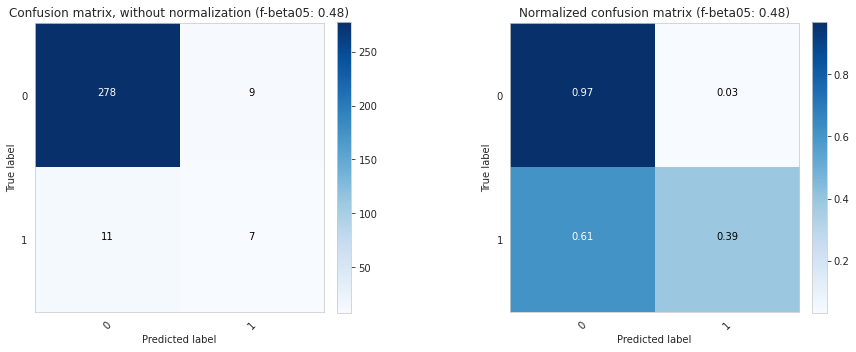

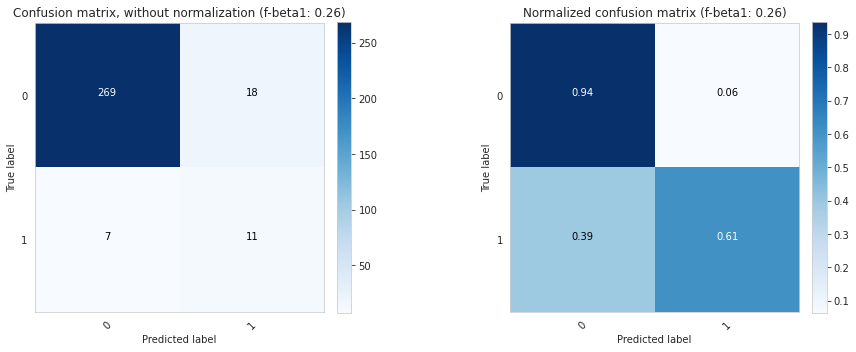

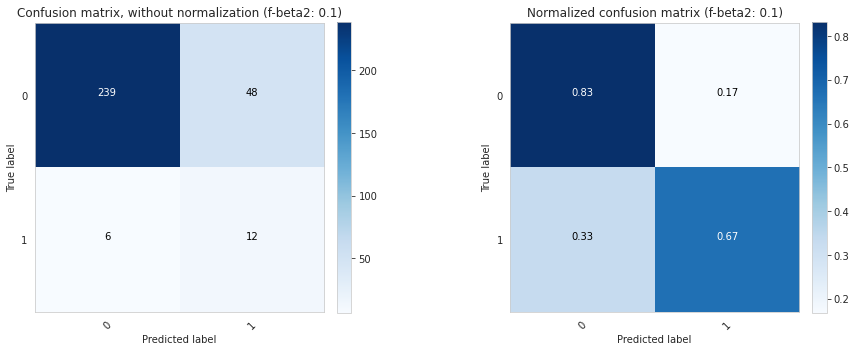



ROC Curve:


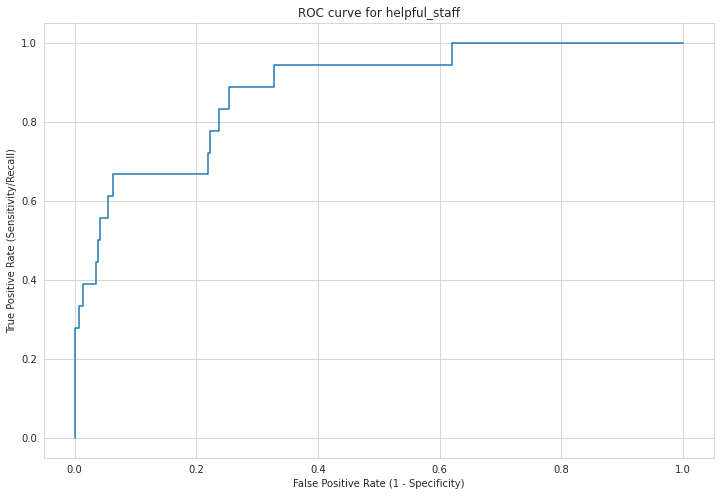

Predicted Probability Distribution:


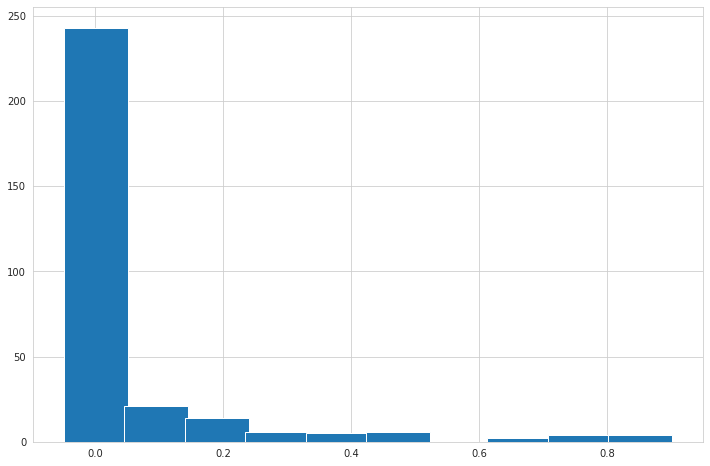



----------------------------------------------------------------------------------------------------


KNOWLEDGEABLE_STAFF

Null Accuracy:	0.9311475409836065
AUC Score:	0.9210261569416498

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9540983606557377	0.9377049180327869	0.9114754098360656	
Cohen's Kappa:	0.58743961352657	0.5032147449635662	0.44436947574387686	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9655              0.9859              0.9756              284                 
1                   0.7333              0.5238              0.6111              21                  
avg/total           0.8494              0.7549              0.7934              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9649              0.9683              0.9666         

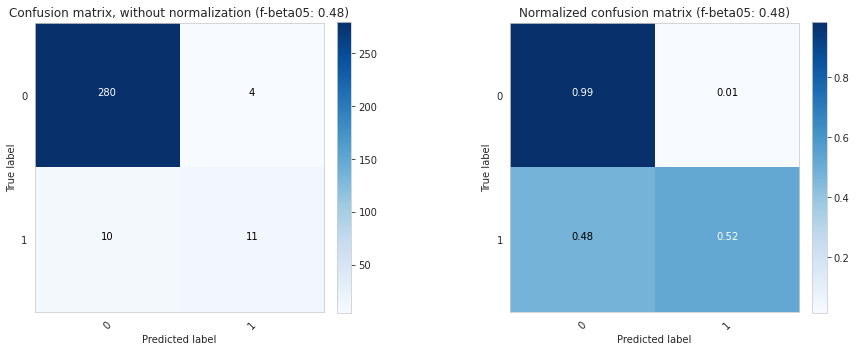

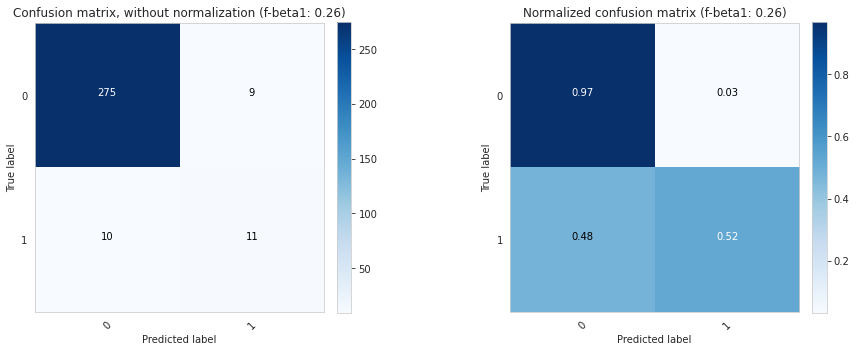

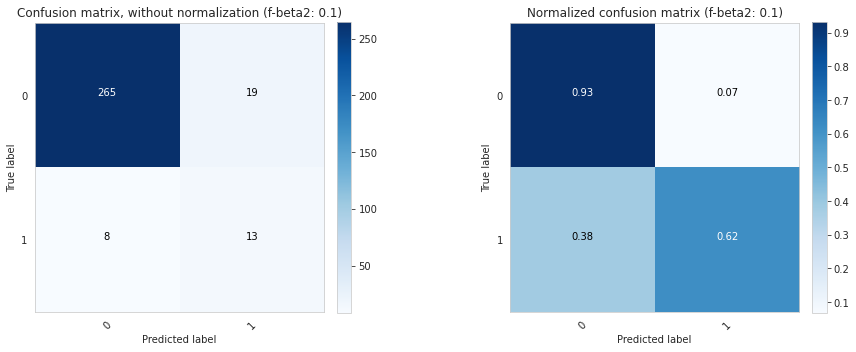



ROC Curve:


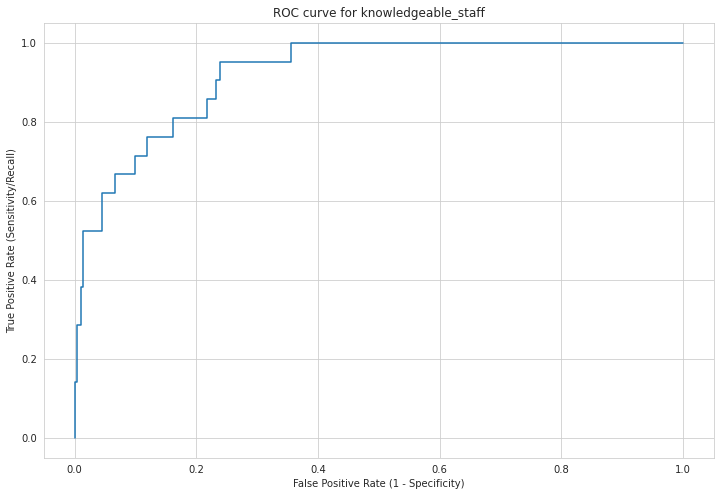

Predicted Probability Distribution:


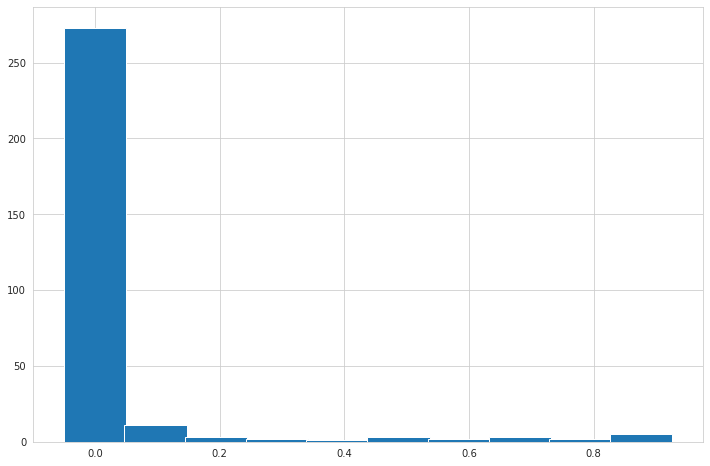



----------------------------------------------------------------------------------------------------


MOVING_IN_A_POSITIVE_DIRECTION

Null Accuracy:	0.9868852459016394
AUC Score:	0.8995016611295681

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9868852459016394	0.9868852459016394	0.9836065573770492	
Cohen's Kappa:	0.0	0.3274531422271224	0.4362292051756007	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9869              1.0                 0.9934              301                 
1                   0.0                 0.0                 0.0                 4                   
avg/total           0.4934              0.5                 0.4967              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9901              0.9967              0.9934            

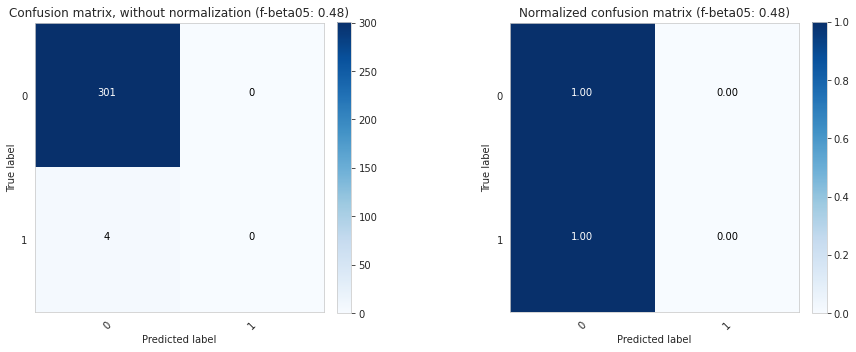

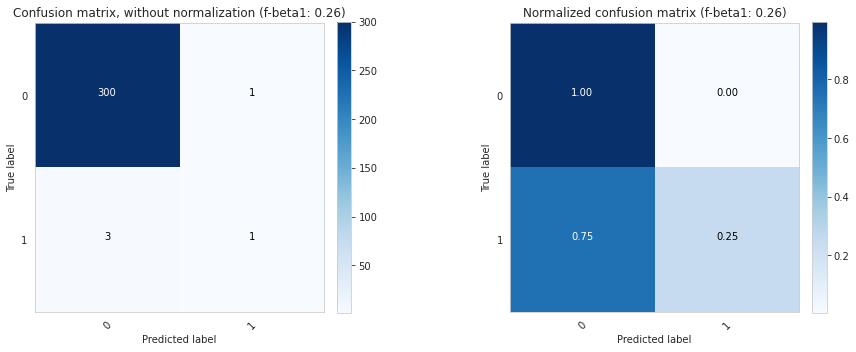

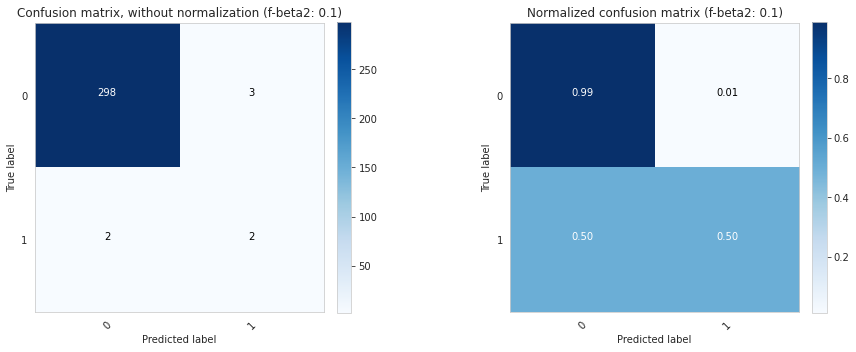



ROC Curve:


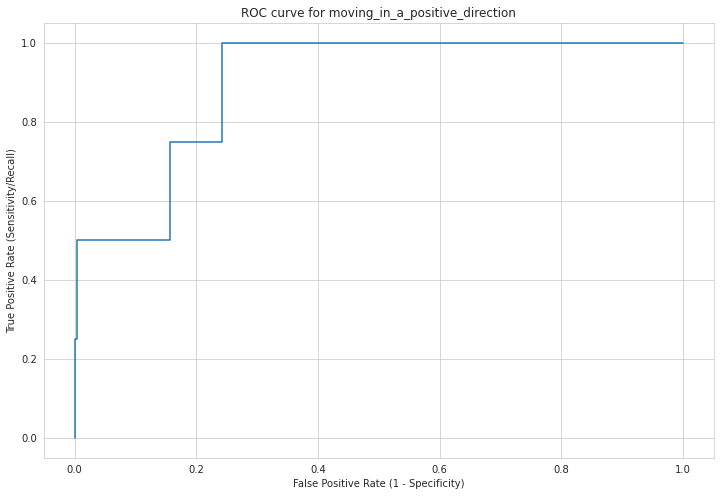

Predicted Probability Distribution:


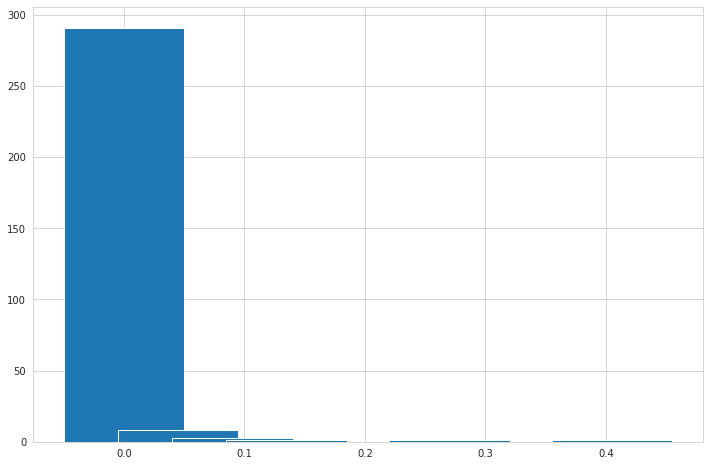



----------------------------------------------------------------------------------------------------


OVERALL_SATISFACTION

Null Accuracy:	0.9114754098360656
AUC Score:	0.9380495603517186

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9475409836065574	0.9540983606557377	0.9311475409836065	
Cohen's Kappa:	0.6247308520455245	0.6951741861793261	0.6396218983851911	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.958               0.9856              0.9716              278                 
1                   0.7895              0.5556              0.6522              27                  
avg/total           0.8738              0.7706              0.8119              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9681              0.982               0.975        

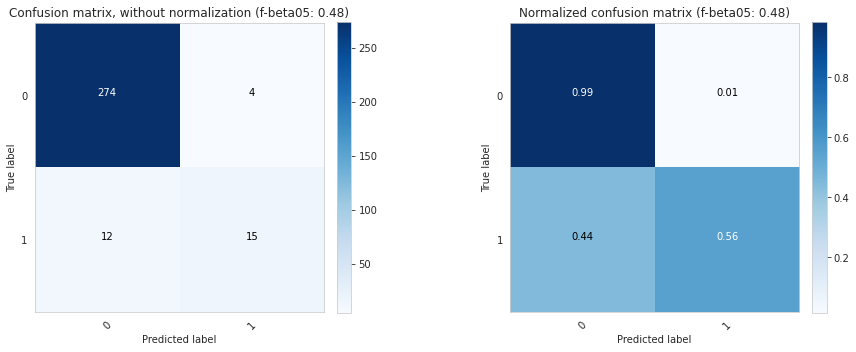

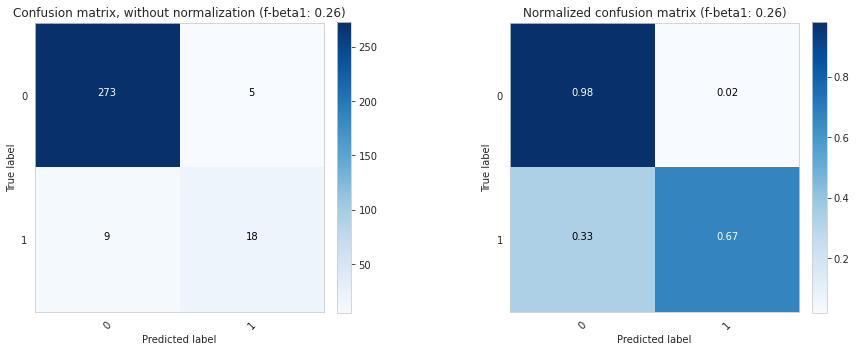

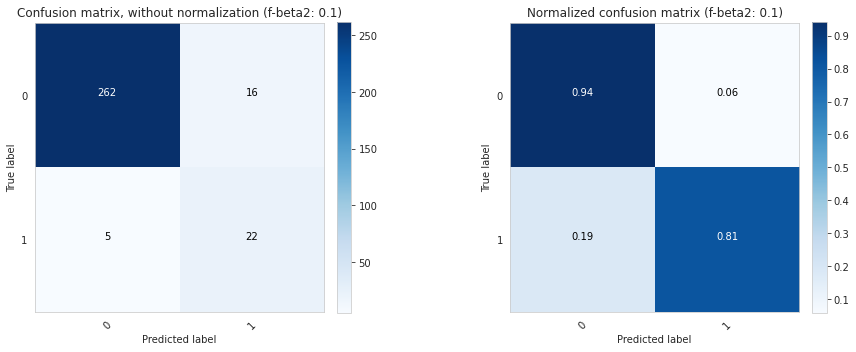



ROC Curve:


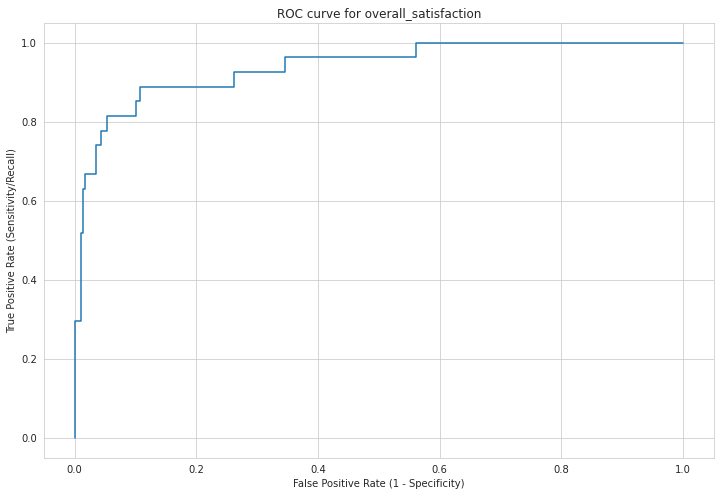

Predicted Probability Distribution:


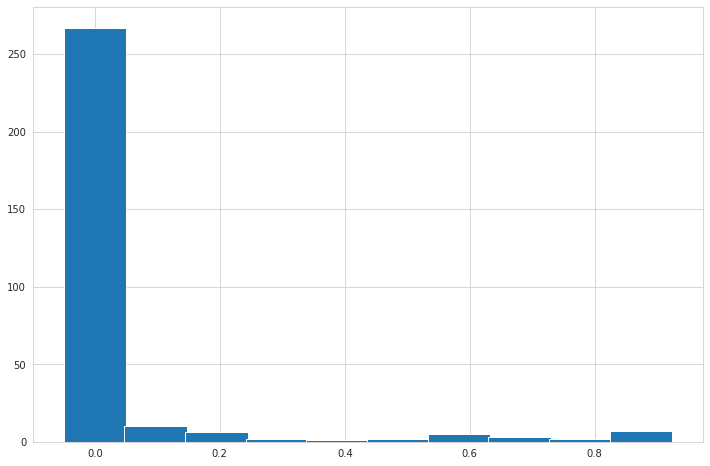



----------------------------------------------------------------------------------------------------


PROCESS_IMPROVEMENT

Null Accuracy:	0.9016393442622951
AUC Score:	0.868

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.898360655737705	0.8754098360655738	0.7967213114754098	
Cohen's Kappa:	0.3151032234697573	0.35503617139677246	0.3422608695652174	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9266              0.9636              0.9447              275                 
1                   0.4737              0.3                 0.3673              30                  
avg/total           0.7001              0.6318              0.656               305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9405              0.92                0.9301              275    

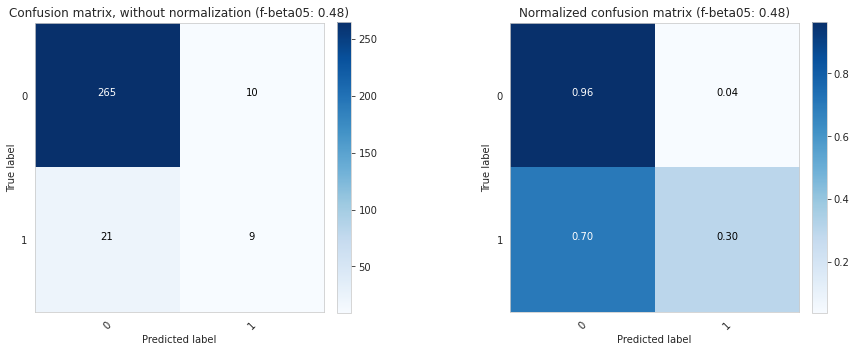

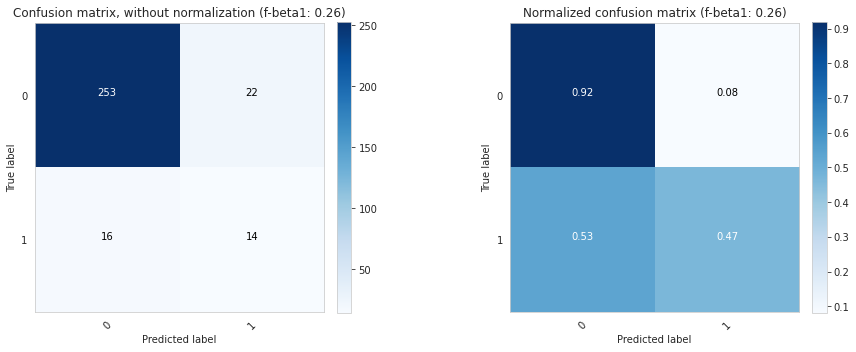

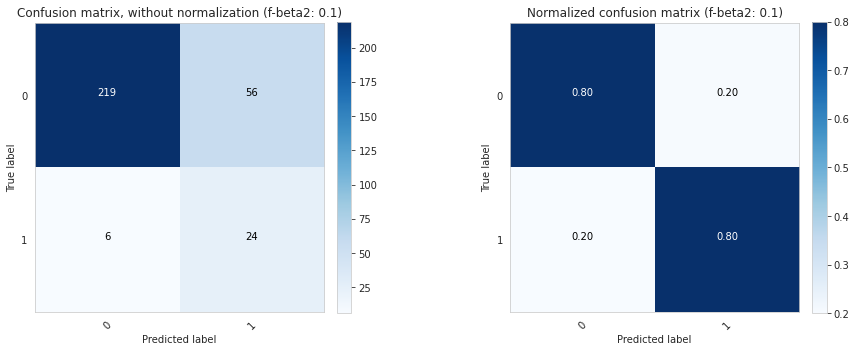



ROC Curve:


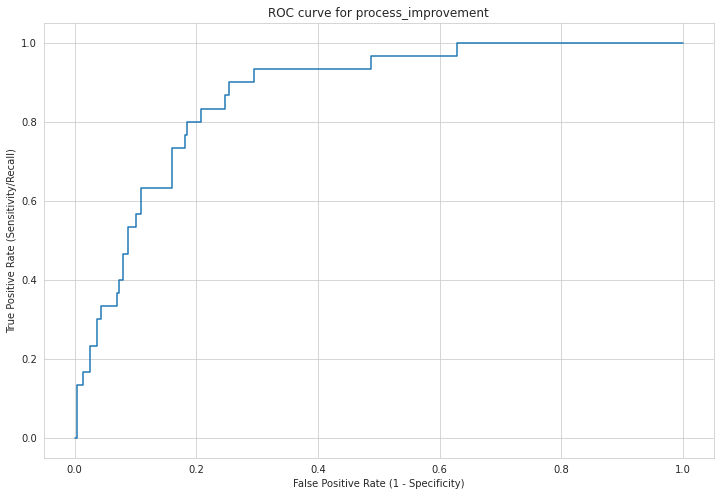

Predicted Probability Distribution:


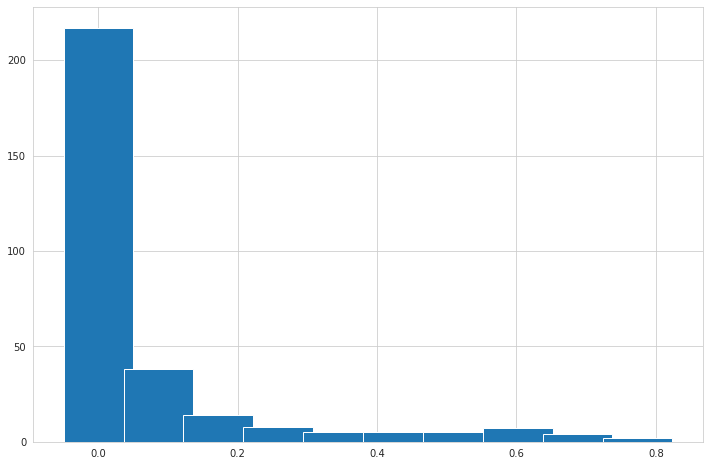



----------------------------------------------------------------------------------------------------


PROVIDES_EFFECTIVE_ADVICE_GUIDANCE

Null Accuracy:	0.9836065573770492
AUC Score:	0.8413333333333333

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9737704918032787	0.9508196721311475	0.9114754098360656	
Cohen's Kappa:	-0.012448132780083165	0.09674234945705829	0.10440456769983697	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9834              0.99                0.9867              300                 
1                   0.0                 0.0                 0.0                 5                   
avg/total           0.4917              0.495               0.4934              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9863              0.9633        

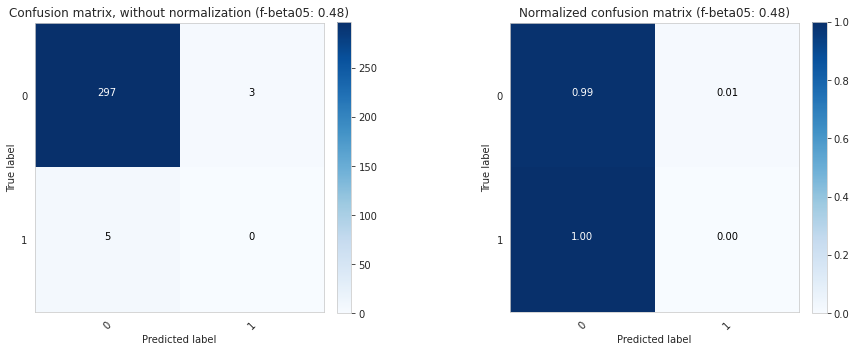

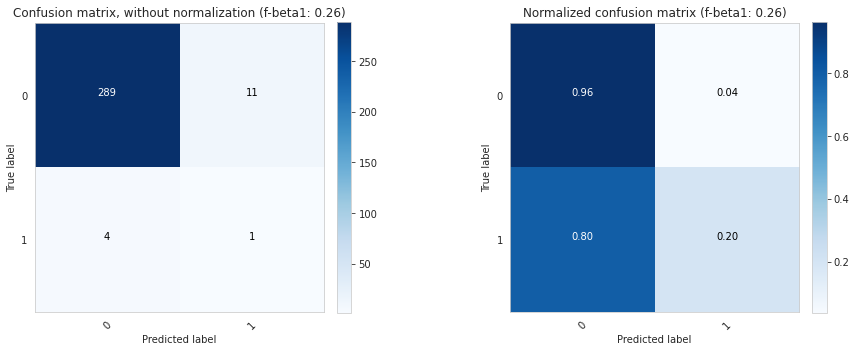

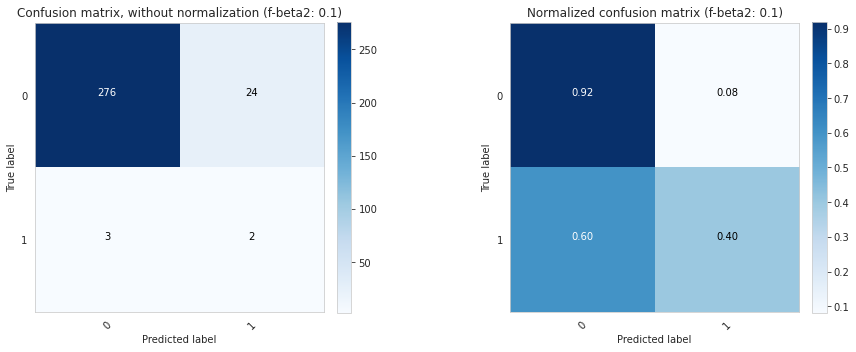



ROC Curve:


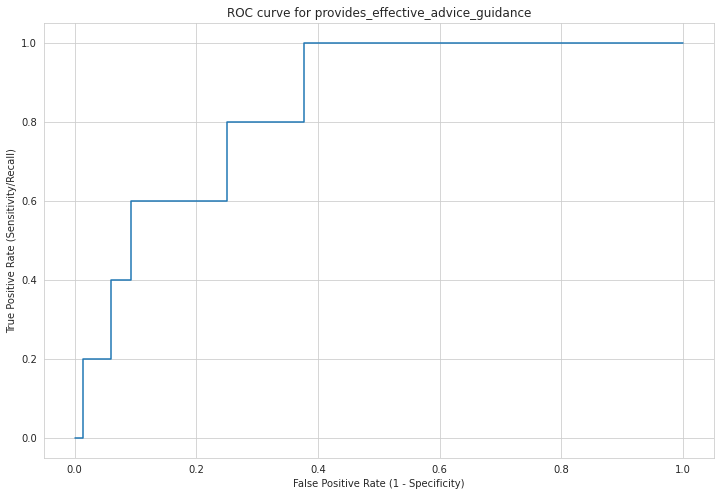

Predicted Probability Distribution:


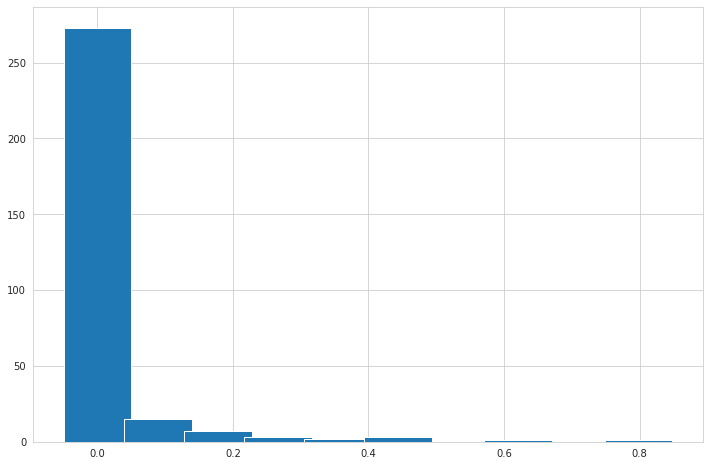



----------------------------------------------------------------------------------------------------


PROVIDES_TRAINING_ON_PROCESSES_APPLICATIONS

Null Accuracy:	0.9737704918032787
AUC Score:	0.9457070707070707

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.980327868852459	0.9737704918032787	0.9540983606557377	
Cohen's Kappa:	0.393638170974155	0.4865319865319865	0.39552661381653453	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9802              1.0                 0.99                297                 
1                   1.0                 0.25                0.4                 8                   
avg/total           0.9901              0.625               0.695               305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9865              0.9865     

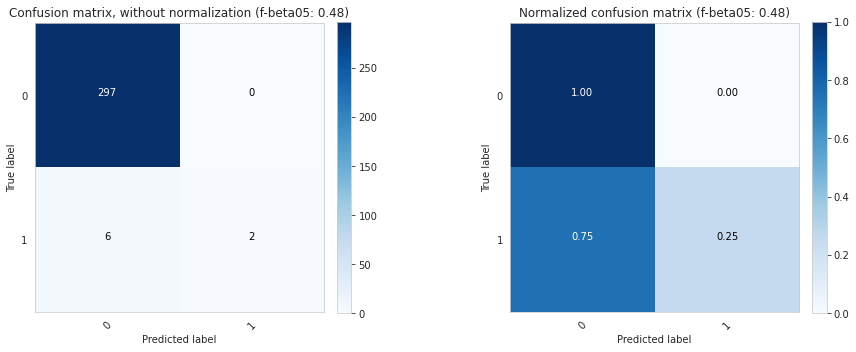

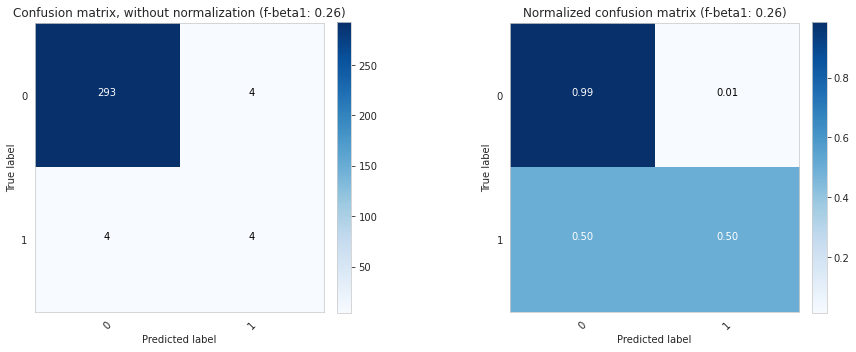

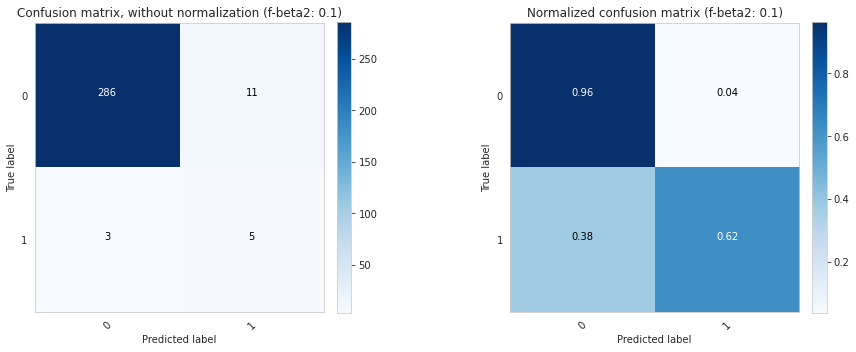



ROC Curve:


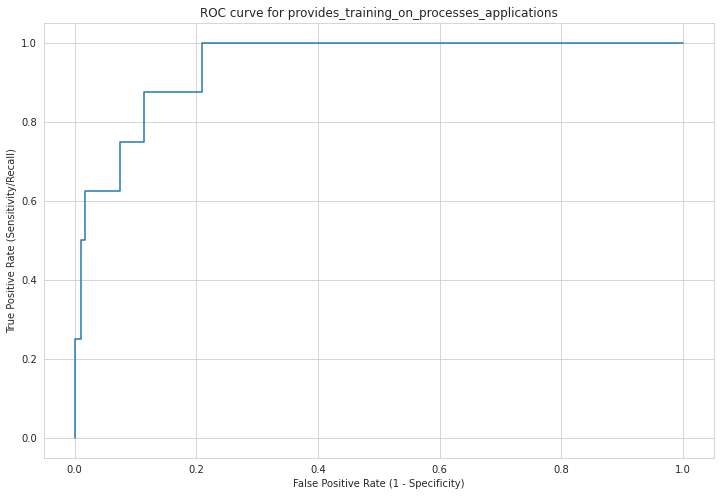

Predicted Probability Distribution:


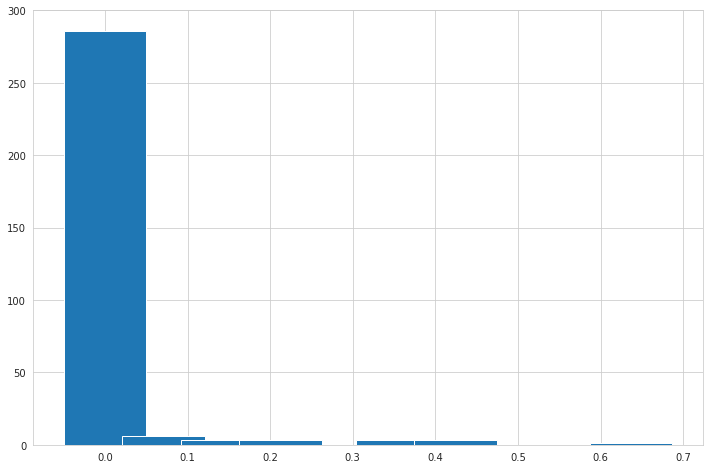



----------------------------------------------------------------------------------------------------


RESOLVES_PROBLEMS_EFFECTIVELY

Null Accuracy:	0.9278688524590164
AUC Score:	0.9020237712817218

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9442622950819672	0.9180327868852459	0.8491803278688524	
Cohen's Kappa:	0.5348524266618822	0.46599901953918343	0.32561045952701406	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9618              0.9788              0.9702              283                 
1                   0.6471              0.5                 0.5641              22                  
avg/total           0.8044              0.7394              0.7672              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9674              0.9435              0.

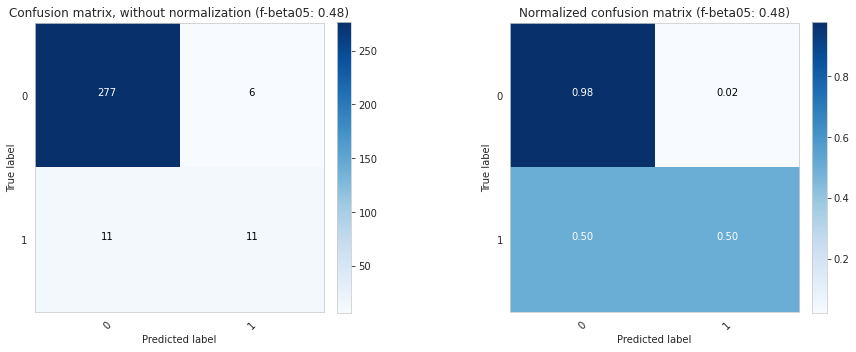

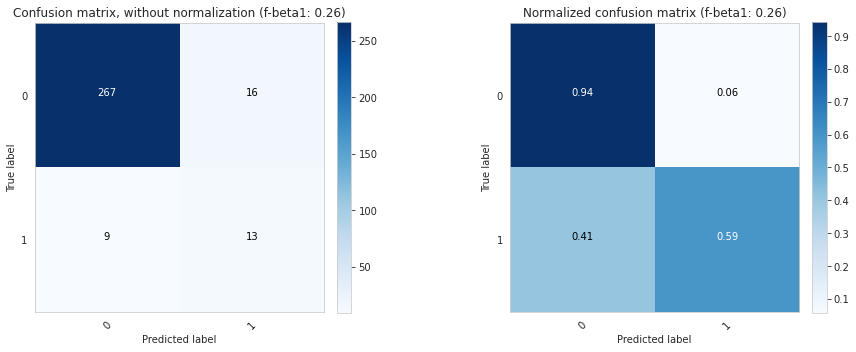

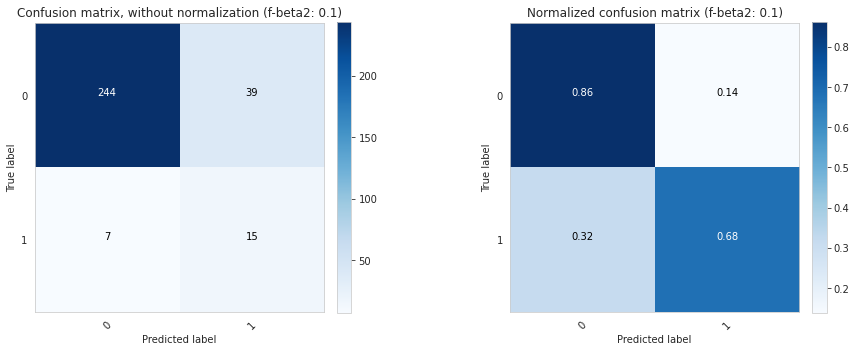



ROC Curve:


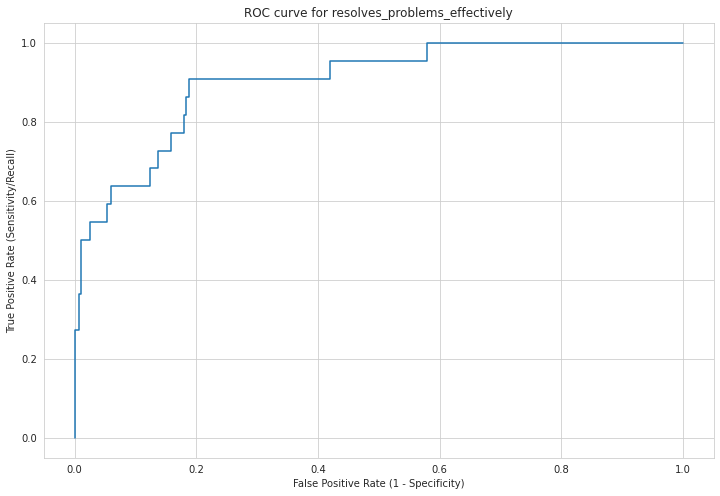

Predicted Probability Distribution:


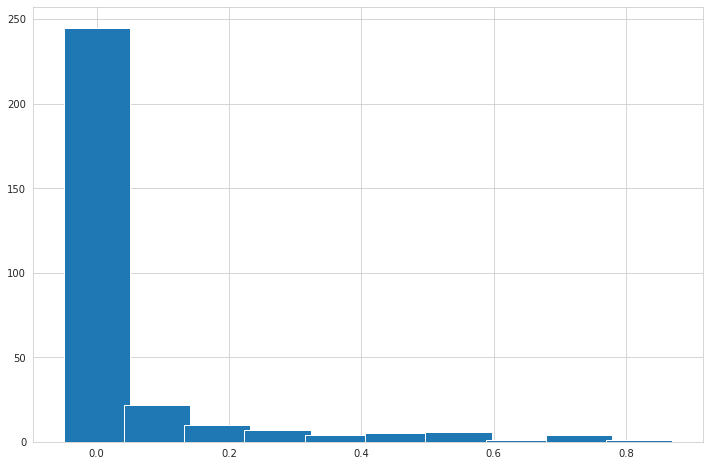



----------------------------------------------------------------------------------------------------


RESPONDS_TO_REQUESTS_WITHIN_AN_ACCEPTABLE_TIME

Null Accuracy:	0.8163934426229508
AUC Score:	0.9424125071715433

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.9081967213114754	0.8852459016393442	0.8786885245901639	
Cohen's Kappa:	0.660922734852696	0.6250043910492851	0.6466923390000313	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9202              0.9719              0.9453              249                 
1                   0.8333              0.625               0.7143              56                  
avg/total           0.8767              0.7984              0.8298              305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.935               0.9237  

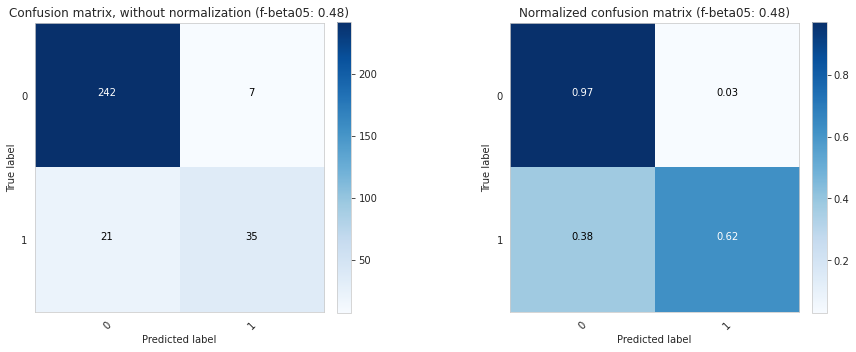

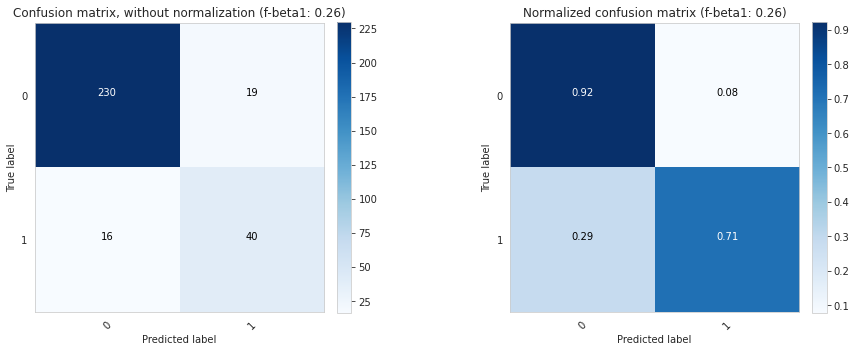

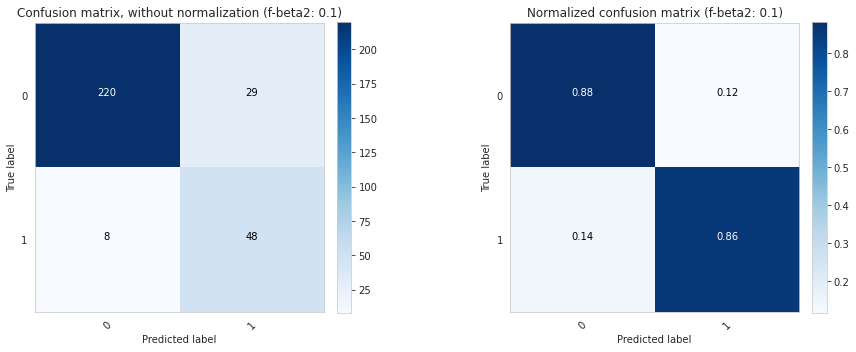



ROC Curve:


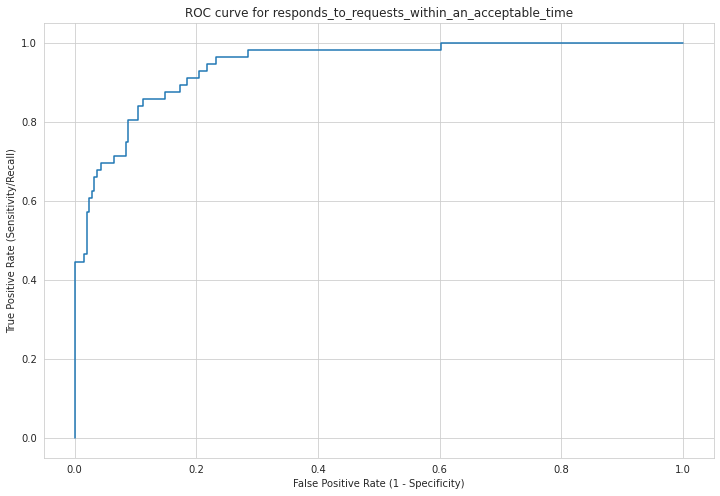

Predicted Probability Distribution:


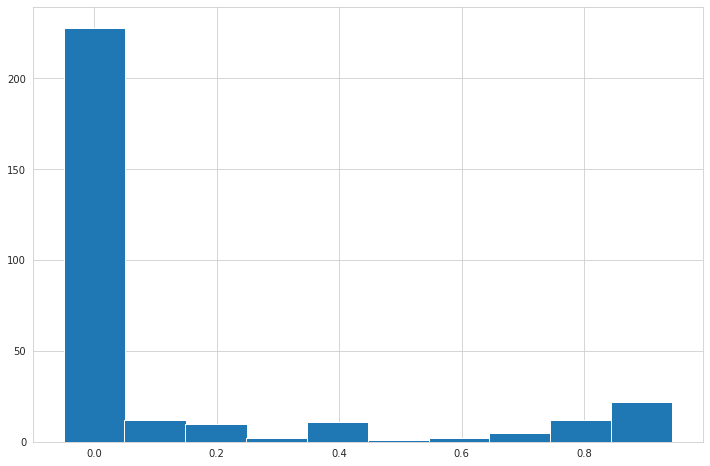



----------------------------------------------------------------------------------------------------


UNDERSTANDS_MY_NEEDS_AND_REQUIREMENTS

Null Accuracy:	0.980327868852459
AUC Score:	0.9715719063545151

		f-beta05(0.48)		f-beta1(0.26)		f-beta2(0.1)
Accuracy:	0.980327868852459	0.9737704918032787	0.9672131147540983	
Cohen's Kappa:	0.0	0.18720852764823448	0.48583951449763996	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9803              1.0                 0.9901              299                 
1                   0.0                 0.0                 0.0                 6                   
avg/total           0.4902              0.5                 0.495               305                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9834              0.99                0.9867     

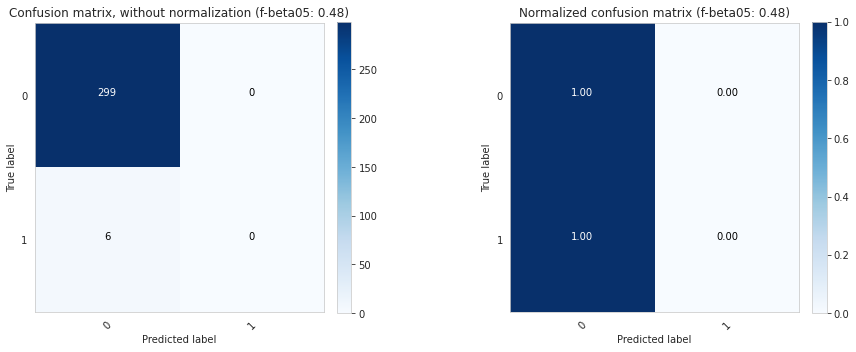

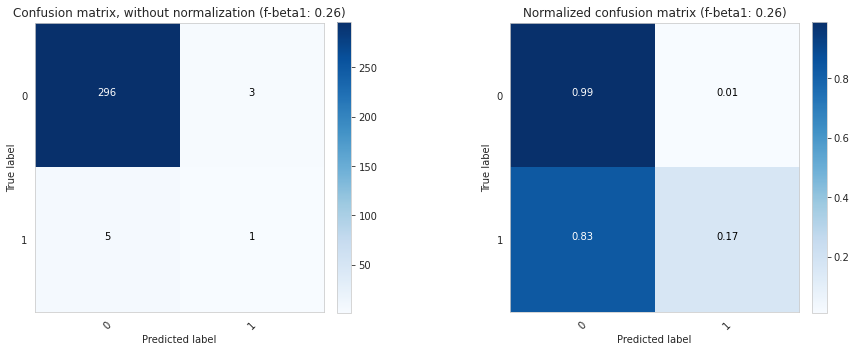

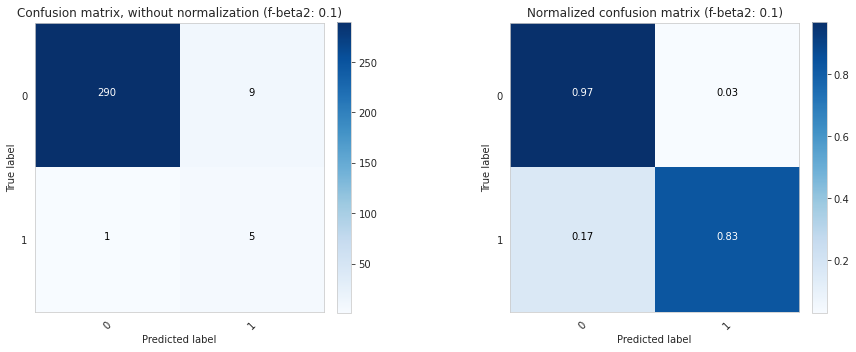



ROC Curve:


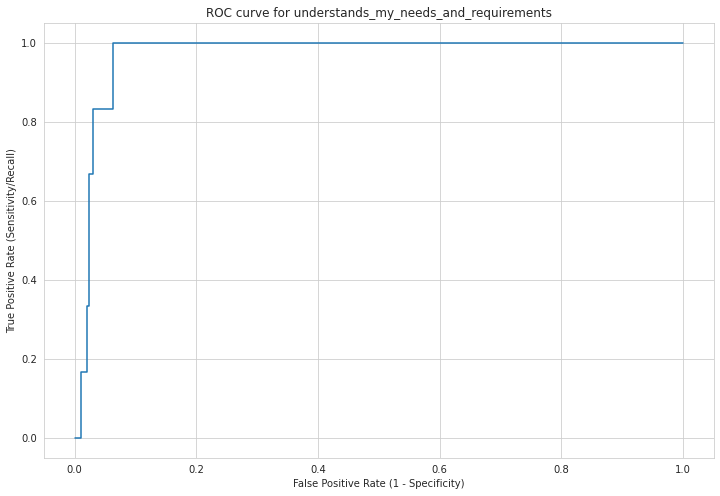

Predicted Probability Distribution:


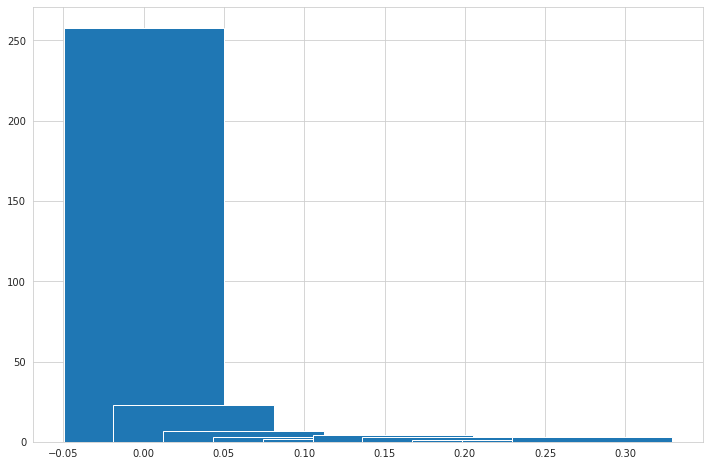



----------------------------------------------------------------------------------------------------




In [69]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Ensemble forwards and backwards (optional) passes

In [70]:
try:
    inf_learn.purge(); inf_learn = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

inf_learn = load_learner(fname=STANDARD_THEME_CSS_PATH/f'{m_pre}export_clas{m_suf}.pkl')
dls = get_css_standard_theme_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [71]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [72]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(torch.Size([305, 16]), torch.Size([305, 16]), torch.Size([305]))

### Results

In [73]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [74]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.4800000000000001 0.26000000000000006 0.1
Fowards Only
-------------
f05:	Optimal threshold = 0.4800000000000001	(Accuracy = 0.9502049088478088)
f1:	Optimal threshold = 0.26000000000000006	(Accuracy = 0.9383196830749512)
f2:	Optimal threshold = 0.1	(Accuracy = 0.903073787689209)

Accuracy: 0.9504098296165466


In [75]:
final_valid_loss = loss.mean().item()

## Codify our training/eval loop and score reporting

In [76]:
#export
def train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={}):
          
    config = {**css_standard_themes_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    df = get_css_standard_theme_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    dls = get_css_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=config)
    
    learn, fit_cbs = get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, train_config=config)
    
    with learn.no_logging(): 
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(3, lr_max=lr_min, cbs=fit_cbs)
        
        learn.unfreeze()
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model)
        learn.export(fname=config['export_filename'])
        
    # ===== fetch scores, probs, targs, losses, and optional f-scores/thresholds ====
    learn = learn.load(config['save_model_filename'])
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate()))
    probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)
    
    # determine optimal threshold based on desired f-score
    average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

    f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)

    scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}
    
    scores['f05']['threshold'] = f05.opt_th(probs, targs)
    scores['f1']['threshold'] = f1.opt_th(probs, targs)
    scores['f2']['threshold'] = f2.opt_th(probs, targs)
    
    scores['f05']['score'] = f05.opt_fscore(probs, targs)
    scores['f1']['score'] = f1.opt_fscore(probs, targs)
    scores['f2']['score'] = f2.opt_fscore(probs, targs)
    
    # save scores from validation set
    yyyymmdd = datetime.today().strftime("%Y%m%d")
          
    with open(f"{config['learner_path']}/{m_pre}model_scores{m_suf}.pkl", 'wb') as f:
        pickle.dump(scores, f)
        
    # save train/validation probs, targs, losses for review
    test_dl = dls.test_dl(df, with_labels=True)
    probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)
    
    probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS])
    targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in STANDARD_THEME_CSS_LABELS])
    losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
    final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)
    
    final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_train_results{m_suf}.csv", index=False)
        
    return scores, final_df

In [77]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(STANDARD_THEME_CSS_LABELS)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with precision_score value: 0.5224542091784596.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 1 with precision_score value: 0.7927716647748202.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


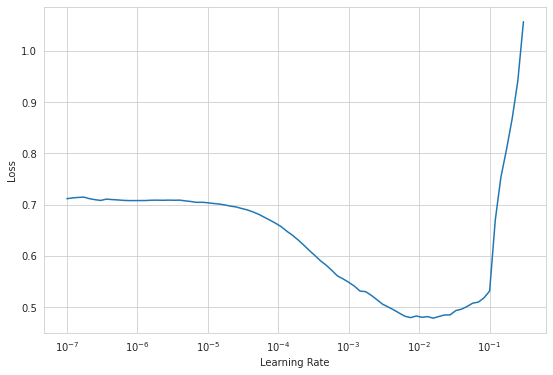

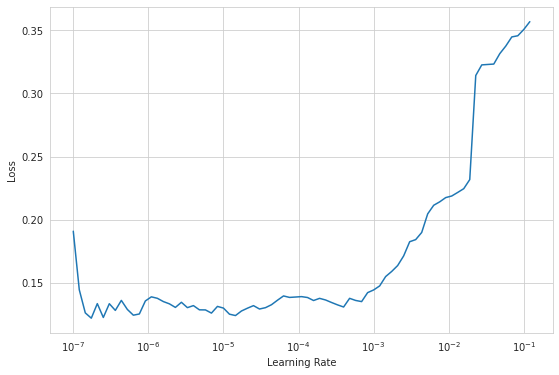

In [78]:
scores, train_res_df = train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={})

In [79]:
scores

{'valid_loss': 0.1572543978691101,
 'accuracy_multi': 0.9471311569213867,
 'fbeta_score': 0.6166150529127031,
 'precision_score': 0.7488167572588279,
 'recall_score': 0.522077922077922,
 'roc_auc_score': 0.7493887712946067,
 'opt_th': 0.49999999999999983,
 'f05': {'threshold': 0.49000000000000005, 'score': 0.6115506703148706},
 'f1': {'threshold': 0.18000000000000005, 'score': 0.5877677446131675},
 'f2': {'threshold': 0.13, 'score': 0.6400184225398066}}

In [80]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,accessible_to_customers,consistency_in_policies_information,cost_fees,courteous_professional_staff,effective_communications,effectively_uses_websites_online_documentation,helpful_staff,knowledgeable_staff,moving_in_a_positive_direction,overall_satisfaction,process_improvement,provides_effective_advice_guidance,provides_training_on_processes_applications,resolves_problems_effectively,responds_to_requests_within_an_acceptable_time,understands_my_needs_and_requirements,labels,is_valid,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,targ_accessible_to_customers,targ_consistency_in_policies_information,targ_cost_fees,targ_courteous_professional_staff,targ_effective_communications,targ_effectively_uses_websites_online_documentation,targ_helpful_staff,targ_knowledgeable_staff,targ_moving_in_a_positive_direction,targ_overall_satisfaction,targ_process_improvement,targ_provides_effective_advice_guidance,targ_provides_training_on_processes_applications,targ_resolves_problems_effectively,targ_responds_to_requests_within_an_acceptable_time,targ_understands_my_needs_and_requirements,loss
0,0,596266,12491,Just continue to communicate with individuals in the areas affected.,NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,453250,Bldg Main & Repair,Let us know your suggestions on how to improve Building Maintenance and Repair Services.,Verbatim-Dept-Improve,134.0,Building_Improve,Building Maintenance & Repair Services,Facilities,"Building, Custodial, Facilities Maintenance",Facilities Maintenance,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,effective_communications,False,0.332310,0.006290,0.000409,0.000208,0.741300,0.002492,0.011072,0.002715,0.000570,0.012194,0.002011,0.027118,0.004417,0.048316,0.148788,0.021328,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062844
1,1,594413,12281,Delaying payment by 2 weeks because of late timesheets is very difficult for staff,NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,456790,Payroll,Let us know your suggestions on how to improve Payroll.,Verbatim-Dept-Improve,88.0,Payroll_Improve,Payroll,Human Resources,Payroll Services,Payroll,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,resolves_problems_effectively,False,0.025859,0.016721,0.014392,0.001623,0.140101,0.000801,0.026007,0.004682,0.000086,0.004315,0.075312,0.002174,0.002099,0.109706,0.818882,0.003377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.265681
2,2,595462,12356,The cashiers can be more customer service friendly.,NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,455925,Sunshine Market,Let us know your suggestions on how to improve Sunshine Market.,Verbatim-Dept-Improve,99.0,Sunshine_Improve,Sunshine Market,Auxiliary Services,"Dining, Catering, & Retail Services",Retail S

In [81]:
# load results
with open(STANDARD_THEME_CSS_PATH/'model_scores_multilabel_hf.pkl', 'rb') as f: training_results = pickle.load(f)
training_results

{'valid_loss': 0.1572543978691101,
 'accuracy_multi': 0.9471311569213867,
 'fbeta_score': 0.6166150529127031,
 'precision_score': 0.7488167572588279,
 'recall_score': 0.522077922077922,
 'roc_auc_score': 0.7493887712946067,
 'opt_th': 0.49999999999999983,
 'f05': {'threshold': 0.49000000000000005, 'score': 0.6115506703148706},
 'f1': {'threshold': 0.18000000000000005, 'score': 0.5877677446131675},
 'f2': {'threshold': 0.13, 'score': 0.6400184225398066}}

In [82]:
inf_learn = load_learner(STANDARD_THEME_CSS_PATH/'export_clas_multilabel_hf.pkl')
print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.49999999999999983


((#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([3.8297e-02, 3.1445e-03, 2.6748e-01, 9.8628e-04, 3.5458e-03, 4.6394e-03,
        3.4173e-02, 3.4513e-04, 3.5814e-05, 2.4507e-01, 1.7645e-03, 3.1981e-03,
        2.1860e-03, 4.9856e-03, 1.1476e-02, 2.6164e-03]))


((#1) ['helpful_staff'], tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False]), tensor([2.1386e-02, 1.6061e-03, 7.0085e-04, 4.7170e-03, 1.9439e-03, 1.9232e-03,
        6.6608e-01, 4.2169e-03, 3.6087e-04, 3.7830e-01, 1.0786e-03, 4.1753e-03,
        5.2292e-03, 3.3598e-03, 5.1963e-03, 7.9377e-02]))


## Inference

### Inference (ad-hoc documents)

In [83]:
print(STANDARD_THEME_CSS_LABELS)

['accessible_to_customers', 'consistency_in_policies_information', 'cost_fees', 'courteous_professional_staff', 'effective_communications', 'effectively_uses_websites_online_documentation', 'helpful_staff', 'knowledgeable_staff', 'moving_in_a_positive_direction', 'overall_satisfaction', 'process_improvement', 'provides_effective_advice_guidance', 'provides_training_on_processes_applications', 'resolves_problems_effectively', 'responds_to_requests_within_an_acceptable_time', 'understands_my_needs_and_requirements']


In [84]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

(HF_BaseInput([   0, 1491, 1199,  615,    4,    2]), (#1) ['cost_fees'], tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([1.7007e-02, 2.8395e-03, 6.7039e-01, 1.5238e-03, 1.7702e-03, 5.7925e-03,
        3.4468e-02, 1.1065e-03, 5.7965e-05, 9.6953e-02, 1.6934e-03, 1.3739e-03,
        1.8900e-03, 2.5325e-03, 1.4070e-02, 2.0163e-03]))


(HF_BaseInput([    0,    38,   524, 10028,    19,   127,  1795,     8,    52,    33,
          615,    82,    11,   127,  1494,     4,    20,  7998,    16,  1266,
            7,   162,     4,     2]), (#1) ['helpful_staff'], tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False]), tensor([1.3934e-02, 8.5574e-03, 5.9108e-03, 9.2661e-02, 2.1764e-03, 3.1103e-03,
        6.0732e-01, 5.3684e-03, 2.3034e-04, 6.5396e-02, 1.6163e-03, 3.8321e-03,
        9.1548e-04, 1.4205e-02, 1.5852e-02, 2.9884e-02]))


(HF_BaseInput([    0,    38,   657, 10017,     2]), (#1) ['overall_satisfaction'], tensor([False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False]), tensor([1.0207e-01, 8.2707e-04, 1.0315e-03, 6.3075e-03, 5.2092e-03, 1.3482e-03,
        3.5366e-01, 4.2223e-04, 2.0003e-04, 7.4153e-01, 1.3447e-03, 4.5579e-04,
        5.8244e-04, 4.6710e-03, 4.6500e-03, 7.5132e-03]))


(HF_BaseInput([    0,    38,    64,   393,   465,    10,  2932,  1514,     4,    20,
         2572,    90,  1634,    32,    45,    15,    86,     4, 10310,     2]), (#1) ['accessible_to_customers'], tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([5.2401e-01, 2.7632e-03, 6.2631e-04, 7.8065e-04, 8.7582e-03, 1.6329e-03,
        3.4382e-01, 1.1547e-03, 9.9041e-04, 1.5302e-01, 3.8363e-02, 2.0923e-03,
        4.0160e-04, 2.3029e-02, 1.9871e-01, 2.3781e-02]))


(HF_BaseInput([    0,    38,    21,   269,  9800,     7,  5486,   127,  2979, 16506,
            2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([6.9166e-02, 2.0900e-02, 1.4008e-03, 2.7357e-02, 1.0358e-02, 1.3643e-02,
        4.4190e-02, 1.2940e-04, 2.0377e-04, 3.7593e-01, 1.6936e-03, 6.6798e-03,
        3.4441e-04, 4.9242e-02, 4.0866e-03, 6.0508e-02]))


(HF_BaseInput([    0,  2321,  8914,   890,    16,    41,  9297,   884,     4,  1437,
           91,    34,  1613,  1065,     8,  1684,     7,  1045,    10,  1313,
          447,  1737,     8,   694,   434,  1616,     4,  1437,   832,  2720,
            7,    39,   165,    16,   542, 27978,   196,     8, 19781,   868,
            4, 37457,   338, 37457,   282, 37457,   338, 37457,   282, 38334,
         3144,  5302,  2478,    16,    10,  1421,     9, 12757,  1673,    13,
         6919,     8, 37513,  1630,  2617,  1820,     4,  1437,   264,    34,
         2208,     5,  2098,     9,   167,    79,  3315,   149,  5322,  4358,
            6, 17805,     6,     8, 13557,  9434,     4,     2]), (#0) [], tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), tensor([0.0085, 0.1655, 0.0034, 0.2649, 0.0114, 0.0018, 0.2917, 0.0378, 0.0077,
        0.0431, 0.0066, 0.0137, 0.0082, 0.1115, 0.0514, 0.3893]))


### Inference (batch)

In [85]:
#export
def get_standard_theme_preds(inf_df, learner_export_path=None, model_scores_path=None,
                             device=torch.device('cpu'), train_config={}):
    
    config = {**css_standard_themes_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): learner_export_path = f"{config['learner_path']}/{config['export_filename']}"
    if (model_scores_path is None): model_scores_path = f"{config['learner_path']}/{m_pre}model_scores{m_suf}.pkl"
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df.dropna(subset=config['corpus_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. add model scores
    with open(model_scores_path, 'rb') as f: training_results = pickle.load(f)
    
    prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    
    for lbl in STANDARD_THEME_CSS_LABELS:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['f05']['threshold']).astype(np.int64)
        
    final_df['valid_loss'] = training_results['valid_loss']
    final_df['accuracy_multi'] = training_results['accuracy_multi']
    final_df['fbeta_score'] = training_results['fbeta_score']
    final_df['precision_score'] = training_results['precision_score']
    final_df['recall_score'] = training_results['recall_score']
    final_df['roc_auc_score'] = training_results['roc_auc_score']
    final_df['opt_th'] = training_results['opt_th']
    final_df['f05_threshold'] = training_results['f05']['threshold']
    final_df['f05_score'] = training_results['f05']['score']
    final_df['f1_threshold'] = training_results['f1']['threshold']
    final_df['f1_score'] = training_results['f1']['score']
    final_df['f2_threshold'] = training_results['f2']['threshold']
    final_df['f2_score'] = training_results['f2']['score']

    inf_learn, inf_dl = None, None; gc.collect()
    
    return final_df, all_probs, STANDARD_THEME_CSS_LABELS

In [86]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

inf_df['answer_text'] = inf_df['AnswerText']  # ['question_text', 'answer_text']

591447 4045


In [87]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, inf_probs, inf_labels = get_standard_theme_preds(inf_df, device=device)
print(preds_df.shape, inf_probs.shape, len(inf_labels))

cuda:1
0
(4045, 84) torch.Size([4045, 16]) 16


In [88]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,pred_accessible_to_customers,pred_consistency_in_policies_information,pred_cost_fees,pred_courteous_professional_staff,pred_effective_communications,pred_effectively_uses_websites_online_documentation,pred_helpful_staff,pred_knowledgeable_staff,pred_moving_in_a_positive_direction,pred_overall_satisfaction,pred_process_improvement,pred_provides_effective_advice_guidance,pred_provides_training_on_processes_applications,pred_resolves_problems_effectively,pred_responds_to_requests_within_an_acceptable_time,pred_understands_my_needs_and_requirements,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,f05_threshold,f05_score,f1_threshold,f1_score,f2_threshold,f2_score
0,589404,1877,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",NaN,English,212,9,SAW,UCSD,451700,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91925.0,6878,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91900.0,SURGERY,91925.0,DIVISION ADMIN,NaN,NaN,NaN,NaN,NaN,NaN,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",0.007745,0.631300,0.001343,0.006299,0.016197,0.009374,0.202279,0.070612,0.001157,0.012290,0.019722,0.134547,0.172586,0.078665,0.059056,0.166068,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.157254,0.947131,0.616615,0.748817,0.522078,0.749389,0.5,0.49,0.611551,0.18,0.587768,0.13,0.640018
1,590946,9440,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,NaN,English,212,9,SAW,UCSD,446277,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,473.0,3616,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,445.0,BUILDING AND CUSTODIAL SERVICES TOTAL STAFF,473.0,BUILDING & CUSTODIAL SERVICES MGRS/ADMIN,NaN,NaN,NaN,NaN,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,0.008537,0.165475,0.003449,0.264902,0.011389,0.001845,0.291712,0.037778,0.007745,0.043106,0.006623,0.013749,0.008154,0.111484,0.051394,0.389285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.157254,0.947131,0.616615,0.748817,0.522078,0.749389,0.5,0.49,0.611551,0.18,0.587768,0.13,0.640018
2,589546,2576,We have had minority staff quit due to unfair and abhorrent treatment by select Sociology facult...,NaN,English,212,9,SAW,UCSD,445689,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral 

In [90]:
yyyymmdd = datetime.today().strftime("%Y%m%d")
preds_df.to_csv(STANDARD_THEME_CSS_PATH/f'{yyyymmdd}_test_predictions{m_suf}.csv', index=False)

*If we were building results DataFrame by hand ...*

Add the probabilities of each label to `inf_df`

In [91]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_CSS_LABELS]
probs_df = pd.DataFrame(inf_probs.numpy(), columns=prob_labels)
probs_df.head()

,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements
0,0.007745,0.631300,0.001343,0.006299,0.016197,0.009374,0.202279,0.070612,0.001157,0.012290,0.019722,0.134547,0.172586,0.078665,0.059056,0.166068
1,0.008537,0.165475,0.003449,0.264902,0.011389,0.001845,0.291712,0.037778,0.007745,0.043106,0.006623,0.013749,0.008154,0.111484,0.051394,0.389285
2,0.012985,0.235559,0.002436,0.110338,0.006326,0.003255,0.213619,0.030163,0.004713,0.012398,0.006261,0.028107,0.003221,0.160018,0.138953,0.037250
3,0.007362,0.008361,0.000993,0.039545,0.013984,0.001439,0.559653,0.000865,0.000585,0.112970,0.001533,0.004979,0.003044,0.011216,0.006593,0.250822
4,0.041155,0.053921,0.004552,0.675715,0.019183,0.003818,0.115161,0.004487,0.001162,0.001500,0.004565,0.001663,0.000321,0.052640,0.157713,0.009054


In [92]:
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f05 threshold

In [93]:
for lbl in STANDARD_THEME_CSS_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f05).astype(np.int64)

In [94]:
final_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_accessible_to_customers,prob_consistency_in_policies_information,prob_cost_fees,prob_courteous_professional_staff,prob_effective_communications,prob_effectively_uses_websites_online_documentation,prob_helpful_staff,prob_knowledgeable_staff,prob_moving_in_a_positive_direction,prob_overall_satisfaction,prob_process_improvement,prob_provides_effective_advice_guidance,prob_provides_training_on_processes_applications,prob_resolves_problems_effectively,prob_responds_to_requests_within_an_acceptable_time,prob_understands_my_needs_and_requirements,pred_accessible_to_customers,pred_consistency_in_policies_information,pred_cost_fees,pred_courteous_professional_staff,pred_effective_communications,pred_effectively_uses_websites_online_documentation,pred_helpful_staff,pred_knowledgeable_staff,pred_moving_in_a_positive_direction,pred_overall_satisfaction,pred_process_improvement,pred_provides_effective_advice_guidance,pred_provides_training_on_processes_applications,pred_resolves_problems_effectively,pred_responds_to_requests_within_an_acceptable_time,pred_understands_my_needs_and_requirements
0,589404,1877,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",NaN,English,212,9,SAW,UCSD,451700,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91925.0,6878,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91900.0,SURGERY,91925.0,DIVISION ADMIN,NaN,NaN,NaN,NaN,NaN,NaN,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",0.007745,0.631300,0.001343,0.006299,0.016197,0.009374,0.202279,0.070612,0.001157,0.012290,0.019722,0.134547,0.172586,0.078665,0.059056,0.166068,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,590946,9440,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,NaN,English,212,9,SAW,UCSD,446277,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,473.0,3616,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",444.0,FACILITIES AND BUILDING SERVICES TOTAL STAFF,445.0,BUILDING AND CUSTODIAL SERVICES TOTAL STAFF,473.0,BUILDING & CUSTODIAL SERVICES MGRS/ADMIN,NaN,NaN,NaN,NaN,Jeff Wadell is an exceptional leader. He has gone above and beyond to create a positive working...,0.008537,0.165475,0.003449,0.264902,0.011389,0.001845,0.291712,0.037778,0.007745,0.043106,0.006623,0.013749,0.008154,0.111484,0.051394,0.389285,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,589546,2576,We have had minority staff quit due to unfair and abhorrent treatment by select Sociology facult...,NaN,English,212,9,SAW,UCSD,445689,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,10410.0,3454,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10007.0,SOCIAL SCIENCES,10410.0,SOCIOLOGY-LATIN AMERICAN STUDIES-AAASRC,NaN,NaN,NaN,NaN,NaN,NaN,We have had minority staff quit due to unfair and abhorrent treatment by select Sociology facult...,0.012985,0.235559,0.002436,0.110338,0.0063

## Cleanup

In [95]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02b_verbatims-sentiment.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02d_verbatims-standard-themes-css-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 99_verbatims-inference.ipynb.
Converted index.ipynb.


## Playground

In [96]:
verbatim_id = 589404

pred_lbls = [ f'pred_{lbl}' for lbl in STANDARD_THEME_CSS_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_CSS_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
Some of the answers that are marked as agreed, as I think there is always room for improvement.  Some employees are not exercising the principles of community and would greatly benefit from some HR training and responsibility and accountability.

=== preds ===
['pred_consistency_in_policies_information']

=== probs ===
[0.63130045]
